# **EUROPEAN MONARCHIES NETWORK**
Our final project consists of a study of the european royal families. We study the members of each family, how they are related to each other, and how they are related to other members of other families. The main pieces of interesting information would be discovering family relationships between different royal houses or countries, because different royal houses from different countries are related to each other due to historical reasons, for example marriages to form alliances or increase power.

It would be interesting to be able to identify common ancestors of the actual Kings and Queens of Europe, like for example Queen Victoria of the United Kingdom.

To do this, the objective is to create a network with the following characteristics:

Nodes:


*   All Kings, Queens, Spouses, and brothers (to expand the network, we can explore the cousins of the monarchs too)
*   Node size based on importance (priority in the line of succession). Being monarchs the nodes with the biggest size.
*   Circular nodes with the images of the character which that node represents.
*   Border colour of the node based on the country or the royal household from the character that the node represents.

Edges:


*   They represent the relationship between two characters or nodes.
*   We can have different colours for different types of relationships (Direct succession/predecession, husband or wife, brotherhood, sons which never accessed the throne)
*   Different types of relationships can be also modeled using width of edges.

# ***Important!!! ***

If some issues occur in running the code, figures could be seen [here](https://nbviewer.org/github/Davide011/Social_Graph/blob/main/COLAB_FINAL_PROJECT.ipynb) .



In [1]:
import string
import pandas as pd
import os
import requests
import re
import pickle
import os.path
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import ipywidgets as widgets
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk.text import TextCollection
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('stopwords')   # you don't need to run this every time if you are not in colab
from wordcloud import WordCloud
from collections import defaultdict
from IPython.display import display
#from google.colab import drive

#drive.mount('/content/drive')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load a full graph from a python .pkl file (if you run this, skip all the network construction part)

In [5]:
# LOAD LOCAL

save_node_dir = r"C:\Users\david\Desktop\CORSI ORAAA\SOCIAL-GRAPH\Final_project\graph"

# chnage the name of the file to load here
graph_file = save_node_dir + "\\" + "graph_all_1450_new.pkl"  #imbrscore
#graph_file = save_node_dir + "\\" + "graph_all_1450.pkl"      # all !!

# load the graph from a file
with open(graph_file, 'rb') as file:
    G = pickle.load(file)
#G =  pickle.load(save_node_dir + "\\" + "graph_1450.pkl")
#G = nx.read_gpickle(save_node_dir + "\\" + "graph.gpickle")

#OK NOW YOU CAN SKIPP all the part below! :D


In [6]:
"""# load the graph from a file
base_path = "/content/drive/MyDrive/Graph_1450"    # path davide
#base_path = "/content/drive/MyDrive"    # path sergi
#base_path = "/content/drive/MyDrive/DTU/Social Graphs 2023/FINAL VERSION/pkl files here (put in your drive to to load in colab!!)"    # path pere
#base_path = './' # Pere local

with open(base_path + "/" + "graph_all_1450_new.pkl", 'rb') as file:
    G = pickle.load(file)
"""

'# load the graph from a file\nbase_path = "/content/drive/MyDrive/Graph_1450"    # path davide\n#base_path = "/content/drive/MyDrive"    # path sergi\n#base_path = "/content/drive/MyDrive/DTU/Social Graphs 2023/FINAL VERSION/pkl files here (put in your drive to to load in colab!!)"    # path pere\n#base_path = \'./\' # Pere local\n\nwith open(base_path + "/" + "graph_all_1450_new.pkl", \'rb\') as file:\n    G = pickle.load(file)\n'

# NETWORK CONSTRUCTION

We will start from a list of the 18 last/latest monarchs in different countries.

In [ ]:

# Given data
data = {
    'country': ['Belgium', 'Bulgaria', 'Denmark', 'Greece', 'Italy', 'Luxembourg', 'Montenegro',
                'Netherlands', 'Norway', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Spain', 'Sweden', 'UK', 'Liechtenstein', 'Monaco'],

    'monarch_name': ['Philippe of Belgium', 'Simeon Saxe-Coburg-Gotha', 'Margrethe II of Denmark', 'Constantine II of Greece',
                     'Umberto II of Italy', 'Henri, Grand Duke of Luxembourg', 'Nicholas I of Montenegro', 'Willem-Alexander of the Netherlands',
                     'Harald V of Norway', 'King Manuel II', 'Michael I of Romania', 'Nicholas II of Russia', 'Peter I of Serbia',
                     'Felipe VI', 'Carl XVI Gustaf', 'Charles III', 'Hans-Adam II, Prince of Liechtenstein', 'Albert II, Prince of Monaco'],

    'time': ['2013 - Present', 'Ended in 1946', '1972 - Present', 'Ended in 1973', 'Effectively ended in 1946',
             '2000 - Present', 'Ended in 1918', '2013 - Present', '1991 - Present', 'Ended in 1910',
             '1927-1930, 1930-1937', 'Ended in 1917', 'Ended in 1921', '2014 - Present', '1973 - Present', '1952 - Present', '2004 - Present', '2005 - Present']
}



# Creating a Pandas DataFrame
df = pd.DataFrame(data)
# Adding a new column with monarch names spaced by underscores
df['monarch_name_spaced'] = df['monarch_name'].str.replace(' ', '_')

df.head()

,country,monarch_name,time,monarch_name_spaced
0,Belgium,Philippe of Belgium,2013 - Present,Philippe_of_Belgium
1,Bulgaria,Simeon Saxe-Coburg-Gotha,Ended in 1946,Simeon_Saxe-Coburg-Gotha
2,Denmark,Margrethe II of Denmark,1972 - Present,Margrethe_II_of_Denmark
3,Greece,Constantine II of Greece,Ended in 1973,Constantine_II_of_Greece
4,Italy,Umberto II of Italy,Effectively ended in 1946,Umberto_II_of_Italy


Many Wikipedia articles have multiple links that redirect to them. If we want to get the correct data for nodes, we have to get the original article that a name/string links to. We can do this via API calls, but that is very costly for graphs with a lot of node, so Instead we've built a link-article dictionary that stores all the redirects we've come across. It can be loaded from a pickle (.pkl) file.

In [ ]:
base_path = "/content/drive/MyDrive/Graph_1450"    # path davide
#base_path = "/content/drive/MyDrive"
#base_path = "/content/drive/MyDrive/DTU/Social Graphs 2023" # path pere

all_redirects = {}
#with open( os.path.join(base_path,'redirects_1450_.pkl'),'rb') as f:
with open( os.path.join(base_path,'all_redirects_plus.pkl'),'rb') as f:
    all_redirects = pickle.load(f)

# People who redirect to other people...
all_redirects['Princess Margarete Karola of Saxony'] = None
all_redirects[' Elena María de Castellví y Shelly'] = None

Here we define auxiliary functions to deal with wikipedia information: getting wikipedia articles from their links, links from text, redirects from links...

In [ ]:
def get_links(line):
    """Returns all Wikipedia links in a given string/line, use with caution to not get unwanted links"""
    #built specifically for malfunctioning "issue" attributes
    links = []
    # lsearch is a list of all the link objects in the line
    lsearch = re.findall( r'\[\[(.*?)\]\]', line)
    for longlink in lsearch:
        # Leaves only the link name from each of the link objects found
        link = longlink.split('|')[0].replace('[','').replace(']','').replace('&nbsp;',' ').replace('_',' ')
        link = get_redirect(link)
        if link is not None:
          links.append(link)

    return links

def get_link(line, keyword=None):
    """
    Returns the first link in a string if keyword isn't passed.
        Otherwise, returns the last link before the keyword
    """
    # Extract wikipedia page link name from a line of text
    lsearch = re.findall( r'\[\[(.*?)\]\]', line)
    idx = 0
    # A bit hacky, finds the last link before a keyword. If keyword not present, will return the last link
    # Right now it only serves to get the correct predecessor (if there are multiple, return the king for example)
    if len(lsearch)>1 and keyword is not None and keyword.lower() in line.lower():
        for idx, el in enumerate(lsearch):
            spl = line.lower().split(el.lower())
            if keyword not in spl[1]:
                idx -= 1 if idx > 0 else 0
                break
    #if len(lsearch)>1 and keyword is not None: print(lsearch)
    longlink = lsearch[idx] if len(lsearch)>0 else None
    link = longlink.split('|')[0].replace('[','').replace(']','').replace('&nbsp;',' ').replace('_',' ') if longlink is not None else None

    # Gives us the link of the original article (if link is a redirect)
    link = get_redirect(link)

    return link

def get_wikitext(page_link):
    """Returns the wikitext from the link passed (or its redirect)"""
    page_link = get_redirect(page_link)
    baseurl = "https://en.wikipedia.org/w/api.php?"
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": page_link
    }
    wikijson = requests.get(baseurl, params=params).json()
    if 'query' not in wikijson.keys(): return None, page_link
    if 'pages' not in wikijson['query'].keys(): return None, page_link
    numkey = list(wikijson['query']['pages'].keys())[0]
    # Check if the wikipedia article actually exists for the link
    if 'revisions' not in wikijson['query']['pages'][numkey].keys(): return None, page_link
    wikitext = wikijson['query']['pages'][numkey]['revisions'][0]['*']

    # Some links in pages are redirects :/ (shouldn't be needed thanks to get_redirect)
    if wikitext is not None and wikitext.lower().startswith('#redirect'):
        page_link = get_link(wikitext)
        wikitext, _ = get_wikitext(page_link)

    return wikitext, page_link

def get_redirect(link):
    """Returns the article link the passed link redirects to if there is one"""
    if link is not None:
        link = link.replace('_',' ')
        #if link.lower().startswith('house') or 'family' in link.lower(): return None
        if link in all_redirects.keys(): return all_redirects[link]
    # Queries the wikipedia API to find a link's redirect
    baseurl = "https://en.wikipedia.org/w/api.php?redirects&"
    params = {
        "action": "query",
        "format": "json",
        "titles": link
    }
    wikijson = requests.get(baseurl, params=params).json()
    if 'query' not in wikijson.keys(): return link
    if 'redirects' in wikijson['query'].keys():
        new_link = wikijson['query']['redirects'][0]['to']
        all_redirects[link]=new_link
        link = new_link
    else:
        all_redirects[link]=link
    #if link.lower().startswith('house') or 'family' in link.lower(): return None
    return link.replace('_',' ')

Function to build a node from a given article name/link. Returns a node item as well as its neighbors in the network. The built nodes will have some attributes from their wikipedia article:
- monarch: wether the person is reigning or has reigned over something in the past.
- house: the royal family the person belongs to
- reign_start: the start of the person's reign, if it has one
- birth/death: the person's date of birth and death (if present)
- person_type: the type that wikipedia gives to this person's infobox's style. This is not very reliable
- parents: the person's parents

Appart from this, the function will return the person's parents, children and predecessor (if the person has one)

In [ ]:
def line_has_attr(attr, line):
    # Check a line from a Wikipedia article for a certain infobox attribute
    return re.match(r'\|\s*'+attr, line) is not None

def get_node(name):
    """Returns a node and neighbors for a link/person name"""
    # Get a node from a wikipedia link name
    try:
        text, name = get_wikitext(name)
    except OSError as e:
        print(e,name,'failed us')
    if text is None: return None, None, None, None, None

    # Initialize all items to None or empty, in the case that they are not present
    predecessor = None
    spouses = []
    house = None
    reign_start = None
    birth = None
    death = None
    offspring = []
    parents = []
    # Used to check if a list of spouses or children has started
    found_issue = False
    found_spouses = False
    has_reign = False
    person_type = None
    # Parse the text line by line, as we'll use the infobox of people's pages
    for line in text.splitlines():
        # '*' represent list items. In this case useful for lists of children/spouses
        if line.startswith('*'):
            if found_issue:
                if get_link(line) is not None:
                    offspring.append(get_link(line))
            elif found_spouses:
                if get_link(line) is not None:
                    spouses.append(get_link(line))
        else:
            #when we reach a non-* character after a list of offspring/spouses, it means it has ended
            found_issue = False
            found_spouses = False
            # All items in the person's infobox start with a vertical line
            if line.startswith('|'):
                # Give priority to predecessor without a number after over predecessorX or regent
                if line_has_attr('predecessor ', line):
                    predecessor = get_link(line, 'king')
                elif line_has_attr('predecessor', line) and predecessor is None:
                    predecessor = get_link(line, 'king')
                elif line_has_attr('father ', line) and get_link(line) is not None:
                    parents.append(get_link(line))
                elif line_has_attr('mother ', line) and get_link(line) is not None:
                    parents.append(get_link(line))
                elif line_has_attr('spouse ', line) and len(spouses)==0:
                    if get_link(line) is not None:
                        spouses.append(get_link(line))
                elif line_has_attr('spouses ', line):
                    found_spouses = True
                elif line_has_attr('house ', line) and house is None:
                    house = get_link(line)
                elif line_has_attr('issue ', line):
                    offspring = get_links(line)
                    found_issue = True
                elif line_has_attr('birth_date ', line):
                    year_search = re.search(r"\b\d{4}\b", line)
                    birth = year_search[0] if year_search is not None else None
                elif line_has_attr('death_date ', line):
                    year_search = re.search(r"\b\d{4}\b", line)
                    death = year_search[0] if year_search is not None else None
                elif line_has_attr('reign ', line):
                    has_reign = True
                    # This takes the first year from the reign
                    year_search = re.search(r"\b\d{4}\b", line)
                    reign_start = year_search[0] if year_search is not None else None
            elif line.lower().startswith('{{infobox ') and person_type is None:
                # We can extract some basic article type from the infobox configuration
                person_type = line[10:].strip().split('|')[0]

    node = (name, {'monarch':has_reign, 'house':house, 'reign_start':reign_start, 'birth':birth, 'death':death, 'person_type': person_type, 'parents': parents})
    if person_type is not None:
      # some weird page types that might end up in the graph due to getting missplaced links
      unwanted_pages = ['settlement', 'coat of arms', 'country', 'royal family', 'monarchy',
                        'noble house', 'french commune', 'civilian attack',
                        'company', 'emblem wide', 'ethnic group', 'family', 'hrhstyles',
                        'manner of address', 'religious group', 'german location', 'italian comune',
                        'polishcoa', 'royal house', 'artwork', 'diocese', 'river']
    for page_type in unwanted_pages:
        if page_type in person_type.lower(): return None, None, None, None, None

    return node, predecessor, spouses, offspring, parents

Now we can get the list of initial monarchs, from which we will start the search, as well as initialize the list of nodes and edges as well as the search lists.

In [ ]:
monarchs = list(zip(df['monarch_name'],df['country']))
monarchs_old = [('Philippe_of_Belgium','Belgium'), ('Margrethe_II_of_Denmark', 'Denmark'), ('Hans-Adam_II,_Prince_of_Liechtenstein', 'Liechtenstein'),
            ('Henri,_Grand_Duke_of_Luxembourg','Luxembourg'), ('Albert_II,_Prince_of_Monaco','Monaco'), ('Willem-Alexander_of_the_Netherlands','Netherlands'),
            ('Harald_V_of_Norway','Norway'), ('Felipe_VI','Spain'), ('Carl_XVI_Gustaf','Sweden'), ('Charles_III','UK')]
connections = []
visited_people = []

nodes = []
edges = []
# Monarchs who reigned before cutoff are not used
cutoff_year = 1450 # 1800

We can now finally explore the connections of our initial monarchs using a BFS algorithm.

The exploration of nodes related via succession is done separately to that of their family connections. This was initially done to explore monarchs in a line of succession differently, and give more importance to the Country of ruling of each. But when growing the graph via more families and older figures, this becomes harder as countries change and so do successions. In this version, all nodes are explored in the same way.

In [ ]:
# Explore the starting monarchs and their predecessors
while len(monarchs) > 0:
    name, country = monarchs.pop()
    if name in visited_people: continue
    visited_people.append(name)
    node, pre, sps, off, pars = get_node(name)
    # If there is no page for the name, skip it (we could add just the name as a node)
    if node is None: continue
    print(pre,' | ', name)

    # This will give all monarchs in the line of predecession the country of the last ruler.
    node[1]['country'] = country
    # We skip people who died after the cutoff year
    if node[1]['death'] is not None and int(node[1]['death']) < cutoff_year:
        continue
    if node not in nodes:
        nodes.append(node)

    # Add edges to the predecessor and family connections
    if pre is not None:
        edges.append((name,pre,{'relationship':'throne'}))
    for sp in sps: edges.append((name, sp, {'relationship':'marriage'}))
    for o in off: edges.append((name, o, {'relationship':'blood'}))
    for p in pars: edges.append((name, p, {'relationship':'blood'}))

    # Add predecessor and family connections to the respective lists to be explored
    monarchs.append((pre,country))
    connections += [spouse for spouse in sps if spouse not in visited_people]
    connections += [child for child in off if child not in visited_people]
    connections += [parent for parent in pars if parent not in visited_people]

print(f'Num monarchs: {len(nodes)}, starting connections: {len(connections)}')
# Explore the connections of the found monarchs (and their connections iteratively)
while len(connections) > 0:
    if(len(connections)%10 == 0): print(f'connections length: {len(connections)}, visited length: {len(visited_people)}')
    name = connections.pop()
    if name in visited_people:
        continue
    #print(name)
    # This should be checked before adding to the connections list, but I'm too lazy to do it now :)
    visited_people.append(name)
    node, _, sps, off, pars = get_node(name)
    # If there is no page for the name, skip it (we could add just the name as a node)
    if node is None:
        continue

    # Skip people who died before the cutoff year
    if node[1]['death'] is not None and int(node[1]['death']) < cutoff_year:
        continue
    nodes.append(node)

    # Add family connections to the respective lists to be explored
    for sp in sps: edges.append((name, sp, {'relationship':'marriage'}))
    for o in off: edges.append((name, o, {'relationship':'blood'}))
    for p in pars: edges.append((name, p, {'relationship':'blood'}))
    connections += [spouse for spouse in sps if spouse not in visited_people]
    connections += [child for child in off if child not in visited_people]
    connections += [parent for parent in pars if parent not in visited_people]

In [ ]:
# Generate graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

Links that don't actually have an article and nodes before the threshold year create empty nodes, we'll remove them

In [ ]:
# Remove edges to empty nodes (edges that connect to nodes not in the node set)
empty_nodes = [n for n in G.nodes if len(G.nodes[n]) == 0]
edges = [e for e in edges if e[0] not in empty_nodes and e[1] not in empty_nodes]
print(f'removed {len(empty_nodes)} empty nodes')

# Re-generate graph (a bit sloppy, but works and is fast enough)
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

removed 914 empty nodes


Code to store the whole graph or the lists of nodes, edges and dictionary of redirects

In [ ]:
len(G.nodes())
#G.nodes["Queen Victoria"].keys()

base_path = "/content/drive/MyDrive/Graph_1450"    # path davide
with open(os.path.join(base_path, 'graph_imbrscore_1450_new.pkl'), 'wb') as graph:
    pickle.dump(G, graph)

In [ ]:
#Save graph
with open(f'{base_path}/redirects_{cutoff_year}.pkl', 'wb') as f:
    pickle.dump(all_redirects, f)
with open(f'{base_path}/nodes_{cutoff_year}', 'wb') as f:
    pickle.dump(nodes, f)
with open(f'{base_path}/edges_{cutoff_year}', 'wb') as f:
    pickle.dump(edges, f)

## ATTRIBUTE CREATION (skip if complete graph is loaded)

In this section we add more attributes to each of the built network's nodes for future analysis. In particular, we will add the "ascendance tree" for each individual, an inbreeding score calculated using the previous, and text information for their Wikipedia articles.

### Ascendance Trees and Inbreeding Attributes






#### Ascendance Trees

Ascendance trees are family trees that only include progenitors of a certain person. Those are parents, grandparents, grandgrandparents etc... We use them to calculate the inbreeding score which is explained in the network analysis section further in this notebook.

An ascendance tree is modeled as a dictionary in which the keys are the names of the progenitors (nodes) and the values are the distance between the origin node and that progenitor.

In [ ]:
# Recursive function to construct ascendance trees. It visits each progenitor until we reach the limit.
def fill_ascendance_tree(G, node_string, ascendance_tree, distance):
  if node_string in G.nodes:
    node_values = G.nodes[node_string]
    parents = node_values["parents"]

    if len(parents) > 0:
      ascendance_tree[parents[0]] = distance
      ascendance_tree = fill_ascendance_tree(G, parents[0], ascendance_tree, distance + 1)

    if len(parents) > 1:
      ascendance_tree[parents[1]] = distance
      ascendance_tree = fill_ascendance_tree(G, parents[1], ascendance_tree, distance + 1)

    return ascendance_tree

  else:
    return ascendance_tree

# This function initiates the recursive loop for each node
def construct_ascendance_trees(G):
  for key, value in G.nodes().items():
    if G.nodes[key] != {}:
      G.nodes[key]['ascendance_tree'] = fill_ascendance_tree(G, key, {}, 1)
    else:
      G.nodes[key]['ascendance_tree'] = {}

In [ ]:
# Execute this code to construct the ascendance trees. KEEP IN MIND THAT IF YOU IMPORTED THE GRAPH FROM A PKL FILE THE ASCENDANCE TREES ARE ALREADY COMPUTED
construct_ascendance_trees(G)

#### Inbreeding Coefficient or Score

The inbreeding coefficient is a coefficient that we use to measure the amount of inbreeding that a person has. More specificaly, the coefficient of inbreeding of an individual is the probability that two alleles at any locus in an individual are identical by descent from the common ancestor(s) of the two parents (https://en.wikipedia.org/wiki/Coefficient_of_inbreeding).

The use and analysis of the inbreeding coefficient are explained later in this notebook in the network analysis section.

In [16]:
dictionary_inbreeding = {}
#outlier_values_imbr ={}

# This function gets the common ancestors of two persons (nodes). It uses the ascendance trees computed previously.
def calculate_common_ancestors(node1, node2, G):
    if node1 and node2 not in G.nodes():
        return None
    else:
        ancestors1 = set(G.nodes[node1]['ascendance_tree'].keys())
        ancestors2 = set(G.nodes[node2]['ascendance_tree'].keys())

        common_ancestors = ancestors1 & ancestors2

        return common_ancestors


# Recursive function to compute the inbreeding coefficient. To compute the inbreeding score we need the inbreeding score of the common ancestors. If that score has not been computed yet, we make a recursive call.
# The inbreeding coefficient is set to 0 if less than 1 parent is registered for a node (we can't get common ancestors)
# Maybe set a constant to assign to people we can't get the inbreeding of instead of 0

def calculate_inbreeding(node_string , G , distance=2):
    # Base cases: node not in graph or score already computed
    if node_string not in G.nodes():
        return 0
    if G.nodes[node_string ]["inbreed_score"] != -1:
        return G.nodes[node_string ]["inbreed_score"]

    # General case, compute
    parents = G.nodes[node_string]['parents'] if G.nodes[node_string]['parents'] is not None else []
    if len(parents) == 2  and parents[0] in G.nodes() and parents[1] in G.nodes():
        node1 = parents[0]
        node2 = parents[1]
        # Weird graph errors where a person redirects to spouse
        if node1 == node2:
            G.nodes[node_string]['inbreed_score'] = 0
            return 0
    else:
        G.nodes[node_string]['inbreed_score'] = 0
        return 0

    common_ancestors = calculate_common_ancestors(node1, node2, G)
    # if list of common ancestors is empty, score = 0
    if not common_ancestors:
        return 0

    # List of common ancestors sorted by distance
    ca_dists = []
    for ca in common_ancestors:
        ancestor_distance_node1 = G.nodes[node1]['ascendance_tree'][ca]
        ancestor_distance_node2 = G.nodes[node2]['ascendance_tree'][ca]
        total_dist = distance + ancestor_distance_node1 + ancestor_distance_node2
        ca_dists.append((ca, total_dist))

    ca_dists = sorted(ca_dists, key=lambda item: item[1])

    # Use n closest common ancestors
    total_inbreeding = 0
    for common_ancestor, total_distance in ca_dists[:13]:
        imbr_common = calculate_inbreeding(common_ancestor , G)
        # ancestor imbreeding score if not plausable value set to 0
        if imbr_common  < 0  or imbr_common >1:
            imbr_common = 0
            total_inbreeding += ( 0.5 ** (total_distance-1) ) * (1+ imbr_common)
        else:
            total_inbreeding += (0.5 ** (total_distance-1) )* (1+ imbr_common)

    # set inbreeding to  -2 if total_inbreeding is  >1.3
    if total_inbreeding > 1.3:
        return -2
    else:
        return total_inbreeding


# We initialize all inbreed scores to -1 to mark them as not computed.
def initialize_inbreed_scores(G):
    for key, value in G.nodes().items():
        if key in G.nodes():
            G.nodes[key]['inbreed_score'] = -1

def calculate_inbreed_scores(G):
    initialize_inbreed_scores(G)

    for key , values in G.nodes.items():
        # We only compute it if the value is -1, which means that hasn't been computed yet.
        if key in G.nodes() and G.nodes[key]['inbreed_score'] == -1:
            score = calculate_inbreeding( key,G)
            #set inbreeding score in the graph
            G.nodes[key]['inbreed_score'] = score



In [17]:
# Execute this code to compute the inbreeding coefficients. KEEP IN MIND THAT IF YOU IMPORTED THE GRAPH FROM A PKL FILE THE INBREEDING COEFFICIENTS ARE ALREADY COMPUTED
calculate_inbreed_scores(G)

In [ ]:
#base_path = "/content/drive/MyDrive/Graph_1450"    # path davide
with open(os.path.join(base_path, 'graph_imbrscore_estimate_1450_new.pkl'), 'wb') as graph:
    pickle.dump(G, graph)


### Text attribute creation




We have use the following short script to extract the text from all the nodes and save it into files locally.

In [ ]:
# Create a folder to store the text of the monarch
preprocess_dir = r"C:\Users\david\Desktop\CORSI ORAAA\SOCIAL-GRAPH\Final_project\monarch_text"  #from your computer

########################### SAVE THE PAGES in local#######################
mapping_table = str.maketrans({"?":"-", "$":"-", "/":"-"  ,"\\":"-",  "*":"-",  "\"":"-",  "<":"-","|":"-",">":"-",  ":":"-" })
file_list=[]  # to haver a list of all downloaded files with their names in filename format!

for name in G.nodes():
    filename = name.translate(mapping_table)
    file_list.append(filename) ## save filenames in a list

    file_path = os.path.join(preprocess_dir, filename + ".txt")
    # Check if the file already exists
    if not os.path.exists(file_path):

        text = get_wikitext(name)

         # save the text in a file
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(str(text))
            f.close()
#############################################################################

**Before running, check if the score dictionaries have been correctyl loaded!**
this part has to be run in local with this configuration! otherwise, all text information has to be uploaded.

Now we can define some auxiliary functions to process the downloaded texts (remove punctuation, set to lowercase...) and do some computation over them.

In [13]:
# remove punctuation
def remove_punctuation_lower(tokens):

    # Define a string containing all punctuation characters
    punctuation_chars = string.punctuation +"'' ``"

    # Remove all punctuation characters from the list of tokens
    tokens_without_punctuation = [token.lower()  for token in tokens if token not in punctuation_chars]
    return tokens_without_punctuation

# function used to count the number of words in te text
def count_words_NLTK(wikitext):
    # without nltk  regular expressions are used :
    #words_pattern = r'\b\w+\b'
    #words = re.findall(words_pattern, wikitext)

    # with nltk
    words=word_tokenize(wikitext)           # WITH nltk
    words= remove_punctuation_lower(words)  # set to lowercase, remove punctuation
    return len(words), words      # return the number of words and the list of words/tokens

#  Load LabMT scores from a file into a dictionary
def load_labmt_scores_FILE(filename , lines_to_skip=4 ):
    labmt_scores = {}
    with open(filename, 'r', encoding='utf-8' ) as file:
        for _ in range(lines_to_skip):  # skip the first 4 lines(title, header, etc.)
            next(file)
        for line in file:
            liness= line.strip().split() # split the line into a list of strings
            #extract  0: word, 2: happiness_average
            word, score = liness[0], liness[2]
            labmt_scores[word] = float(score)  # add the word and its score to the dictionary
    return labmt_scores   # return the dictionary

# compute sentiment score of a text
def compute_sentiment(tokens, dictionary_sentiment_scores):
        """
        Compute the sentiment score of a text based on LabMT word scores.
        All tokens has to be already formatted (lower case, no punctuation, etc.)
        """
        #clean the tokens from punctuation and set to lowercase (use the function defined above)
        tokens= remove_punctuation_lower(tokens)
        score = 0                        # initialize the score to 0
        token_len=len(tokens)
        for token in tokens:                                  # select each token in the text
                if token not in dictionary_sentiment_scores:  # if the token is not in the dictionary, skip it
                        token_len-=1             # and don't count it in the average
                else:
                        score += dictionary_sentiment_scores[token] # add the score of the token to the total score
        if token_len==0: return 0
        return score/(token_len)  # return the average score for the list of tokens

def compute_sentiment_health(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores['compound']


In [14]:
# stored LabMT data from git
#file_path_score = "temp_directory/Data_Set_S1.txt"
# load from pc
file_path_score_1=r"C:\Users\david\Desktop\CORSI ORAAA\SOCIAL-GRAPH\W8\Data_Set_S1.txt"
file_path_score_2=r"C:\Users\david\Desktop\CORSI ORAAA\SOCIAL-GRAPH\W8\Data_Set_S1.txt"

# Load LabMT scores from a file into a dictionary_1
sentiment_dict_1= load_labmt_scores_FILE(file_path_score_1)

Finally, we can add all this new text information in the form of token lists to each node in the graph.

In [44]:
# add text information to nodes in the graph
for name in G.nodes():
    filename = name.translate(mapping_table)
    # extract text from the file
    file_path = os.path.join(preprocess_dir, filename + ".txt")
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()
        f.close()
    count, tokens =count_words_NLTK(text)
    s_score_1 = compute_sentiment(tokens, sentiment_dict_1)   # compute sentiment score of the page
    s_score_2 = compute_sentiment_health(text)


    G.nodes[name]['count'] = count
    G.nodes[name]['tokens'] = tokens
    G.nodes[name]['sentiment_score_1'] = s_score_1
    G.nodes[name]['sentiment_score_2'] = s_score_2

NameError: name 'mapping_table' is not defined

In [ ]:
# check attributes are correctly created
G.nodes['Elizabeth II'].keys()

# NETWORK ANALYSIS

In this section we perform a basic analysis on the network to understand its structure.

## Basic analysis

We will first examine the most basic metrics in our network. The most interesting observation here is that the graph is connected, which means that all people in the graph are connected to each other in some way.

In [18]:
# Number of nodes/edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print('The number of nodes in all the networkare : ',num_nodes)
print('The number of edges in all the network are : ',num_edges)
print('The number of connected components :', len(list(nx.connected_components(G))))

The number of nodes in all the networkare :  7365
The number of edges in all the network are :  13259
The number of connected components : 1


For each node or person, we store a set of attributes for further analysis. We extract these attributes from the Wikipedia infobox. The attributes are the following:
- Monarch: Indicates if the person is a King or Queen. This attribute is useful for analysing which royal houses had more positions of power throughout history.

- House: Indicates the house of the royal (for example, House of Bourbon). It is useful again for further data analysis and visualization.

- Reign Start: The date in which the reign started, in case the person was a Monarch. Can be useful for data visualization and data filtering.

- Birth and Death: Dates of birth and death respectively. It can also be used for data visualization and filtering.

- Parents: Holds references to the parents nodes of the person. This is useful to construct ascendance trees as we will see further in the notebook.

- Country: Indicates the country of the royal. It is useful as sometimes a same royal house can rule in different countries. For example, the House of Bourbon is traditionally the french royal house but it currently rules in Spain.

Below we can see an example of the node for Felipe VI, the current king of Spain.

In [19]:
# Let's take a look at the node attributes of Felipe VI King of Spain
felipe_VI = G.nodes['Felipe VI']
for attribute_key, attr in felipe_VI.items():
    if type(attr) not in [list, dict] or len(attr) < 10:
        print(f'{attribute_key}: {str(attr)}')
    else:
        print(f'{attribute_key}: {str(attr[:10]) if type(attr) == list else str(list(attr)[:10])}...')

monarch: True
house: House of Bourbon
reign_start: 2014
birth: 1968
death: None
person_type: royalty
parents: ['Juan Carlos I', 'Queen Sofía of Spain']
country: Spain
ascendance_tree: ['Juan Carlos I', 'Infante Juan, Count of Barcelona', 'Alfonso XIII', 'Alfonso XII', 'Francisco de Asís, Duke of Cádiz', 'Infante Francisco de Paula of Spain', 'Charles IV of Spain', 'Charles III of Spain', 'Philip V of Spain', 'Louis, Grand Dauphin']...
inbreed_score: 0.003509246703288227
count: 14057
tokens: ['short', 'description|king', 'of', 'spain', 'since', '2014', 'use', 'dmy', 'dates|date=august', '2020']...
sentiment_score_1: 5.4071634893126825
sentiment_score_2: 0.9999


Below we will do a bit more analysis on the properties of the graph, this time focusing on degrees.

The average degree in the network is:  3.6005431093007467


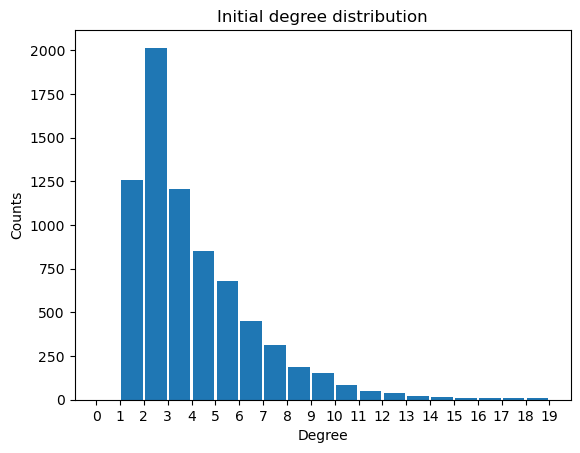

In [20]:
# Degree Analysis

print('The average degree in the network is: ',(num_edges*2)/num_nodes)
degs = [len(node_adj[1]) for node_adj in G.adjacency()]
plt.hist(degs, align="mid", rwidth=0.9, bins=range(20))
plt.title('Initial degree distribution')
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.xticks(range(20))
plt.show()


**Figure 1.1** <br>
In our network, the degree is determined by family and descendance, so it depends mainly on the amount of sons, daughters, and siblings a person has. Because of this, we don't get many extreme values.

We see that the average degree is 3.75, which makes sense as a lot of people in the graph still hasn't had any kids.

## Network Visualization

Now we will work a bit on visualizing our notebook. They say that an image is worth more than a thousand words, but an image of a network with 7000+ nodes without proper processing is probably worth less than a couple. So we will start by defining styles for nodes and edges according to their propperties.

In [21]:
import random
def get_all_countries_colors(G):
  country_colors = {}
  for node, values in G.nodes.items():
    if 'country' not in values:
      continue

    country = values['country']
    if country not in country_colors:
      color = str(hex(random.randrange(0, 2**24)))[2:]
      while len(color) < 6:
        color = color + "0"
      country_colors[country]  = '#' + color

  return country_colors

def get_all_houses_colors(G):
  house_colors = {}
  for node, values in G.nodes.items():
    if 'house' not in values:
      continue

    country = values['house']
    if country not in house_colors:
      color = str(hex(random.randrange(0, 2**24)))[2:]
      while len(color) < 6:
        color = color + "0"
      house_colors[country]  = '#' + color

  return house_colors

def get_all_relationship_colors(G):
  relationships = ["blood", "marriage", "throne"]
  relationship_colors = {}
  for relationship in relationships:
    color = str(hex(random.randrange(0, 2**24)))[2:]
    while len(color) < 6:
      color = color + "0"

    relationship_colors[relationship] = '#' + color
  return relationship_colors

country_colors = get_all_countries_colors(G)
relationship_colors = get_all_relationship_colors(G)
house_colors = get_all_houses_colors(G)

#print(country_colors)    # we can remove the print here
#print(relationship_colors)
#print(house_colors)

It will probably be useful to visualize subgraphs of the big one, so we've made a function for just that. This way we can filter with a list of countries or houses. We also have the option to only show people who reigned over something.

In [22]:
def filter_graph(G, countries, houses, based_on_houses, based_on_countries, only_monarchs):

    if based_on_countries:
        nodes = (
            node
            for node, data
            in G.nodes(data=True)
            if data.get("country") in countries
            )
    elif based_on_houses:
        nodes = (
            node
            for node, data
            in G.nodes(data=True)
            if data.get("house") in houses
            )
    subgraph = G.subgraph(nodes)
    return subgraph

In [23]:
graph_countries = ["Spain", "UK"]
graph_houses = ["House of Bourbon", "House of Bourbon-Parma", "Spanish royal family"]
based_on_countries = False
based_on_houses = True
only_monarchs = False
with_labels = True

filtered_graph = filter_graph(G, graph_countries, graph_houses, based_on_houses, based_on_countries, only_monarchs)

In [24]:
def draw_network(G, based_on_countries, based_on_houses, label_size,figure_size=(8,8)):

  country_colors = get_all_countries_colors(G)
  countries = country_colors.keys()
  relationship_colors = get_all_relationship_colors(G)
  house_colors = get_all_houses_colors(G)
  houses = house_colors.keys()

  relationships = nx.get_edge_attributes(G, "relationship", default = "blood")

  if based_on_countries:
    node_colors = [country_colors[person['country']] if 'country'in person.keys() else '#000000' for person in G.nodes().values() ]
    patches = [mpatches.Patch(color=color, label=country) for country, color in country_colors.items()] + [mpatches.Patch(color=color, label=relationship) for relationship, color in relationship_colors.items()]

  elif based_on_houses:
    node_colors = [house_colors[person['house']] if 'house'in person.keys() else '#000000' for person in G.nodes().values() ]
    patches = [mpatches.Patch(color=house_colors[house], label=house) for house in houses] + [mpatches.Patch(color=color, label=relationship) for relationship, color in relationship_colors.items()]

  edge_colors = [relationship_colors[relationships[edge]] for edge in G.edges() ]
  # Temporary oversiplification for easy viewing. Size can be scaled on degree, importance(kings vs plebs), reign length?, ...
  node_sizes = [150 if 'country' in person.keys() else 75 for person in G.nodes().values() ]

  plt.figure(figsize=figure_size)
  pos = nx.spring_layout(G)
  nx.draw(G, node_color=node_colors, edge_color = edge_colors, node_size=node_sizes, width = 3, pos = pos)
  nx.draw_networkx_labels(G, pos=pos, font_size=label_size)
  plt.legend(handles=patches)
  plt.show()

Below we can see all of our previous visualizing functions in action. In this case, we're filtering the graph to only show people from three Bourbon-related royal families.

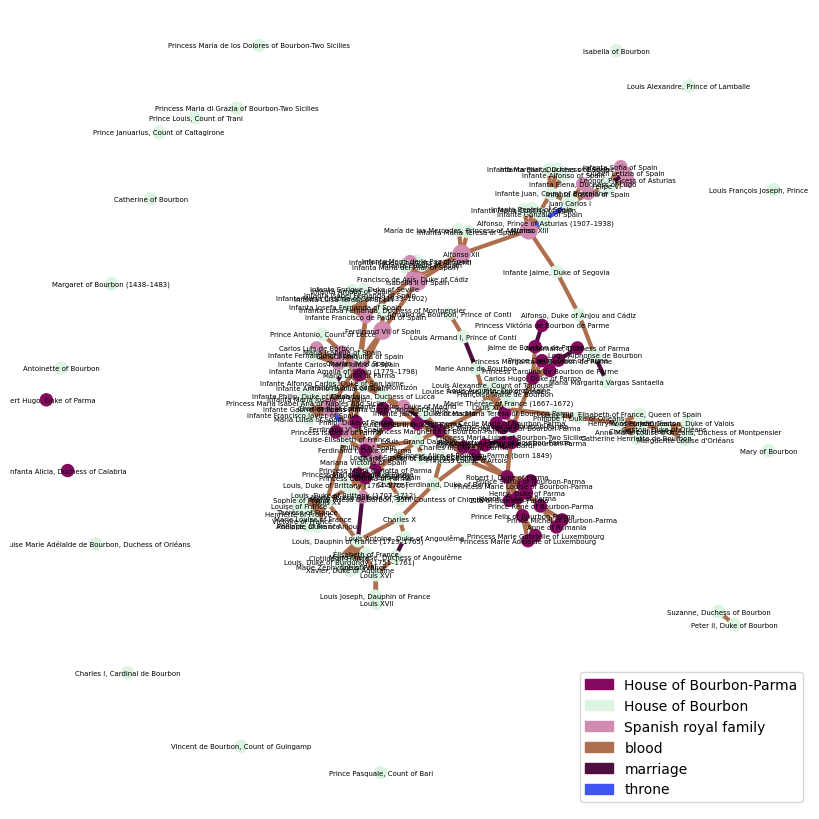

In [25]:
draw_network(filtered_graph, False, True, 5)

 **Figure 1.2** Visualization of the subgraph formed by people from the houses of Bourbon, Bourbon-Parma and the Spanish royal family (also a branch from the Bourbon family). Nodes without edges are connected to people from other Bourbon branches not present in the visualization.<br>




## Paths and Distances Study

In our initial presentation of our topic, we mentioned that we find the topic of monarchies very interesting because the different monarchies across europe are related to each other and different kings from different countries are often family. In this section we are going to explore this by performing a pathology study and seeing if we can draw paths between different monarchs.

We start by trying to calculate the shortest path between two given nodes to see the family relationship between any two given monarchs. We invite you to play and try different monarchs!

In [26]:

# Get a list of all monarchs in your graph
all_monarchs = list(G.nodes)

# Create interactive dropdown widgets for choosing origin and destination monarchs
origin_dropdown = widgets.Dropdown(
    options=all_monarchs,
    value=all_monarchs[0],
    description='Origin Monarch:',
)

destination_dropdown = widgets.Dropdown(
    options=all_monarchs,
    value=all_monarchs[-1],
    description='Destination Monarch:',
)

# Button to trigger the display of the shortest path
display_button = widgets.Button(description="Display Shortest Path")
output = widgets.Output()

# Function to update the shortest path based on the selected monarchs
def update_shortest_path(change):
    origin_monarch = origin_dropdown.value
    destination_monarch = destination_dropdown.value

    shortest_path = nx.shortest_path(G, source=origin_monarch, target=destination_monarch)
    shortest_path_subgraph = G.subgraph(shortest_path)

    # Print or visualize the shortest path as needed
    print(shortest_path)

    with output:
        #plt.figure(figsize=(4, 4))
        pos = nx.spring_layout(shortest_path_subgraph)
        draw_network(shortest_path_subgraph, False, True, label_size = 10, figure_size= (7,4))
        plt.show()

# Attach the update_shortest_path function to the dropdowns' observe method
origin_dropdown.observe(update_shortest_path, names='value')
destination_dropdown.observe(update_shortest_path, names='value')

# Function to handle button click
def on_button_click(b):
    output.clear_output()
    update_shortest_path(None)

# Attach the function to the button's on_click event
display_button.on_click(on_button_click)

# Display the dropdown widgets and the button
display(origin_dropdown)
display(destination_dropdown)
display(display_button)
display(output)

# Initial update to show the shortest path for the default monarchs
update_shortest_path(None)


Dropdown(description='Origin Monarch:', options=('Albert II, Prince of Monaco', 'Rainier III, Prince of Monaco…

Dropdown(description='Destination Monarch:', index=7364, options=('Albert II, Prince of Monaco', 'Rainier III,…

Button(description='Display Shortest Path', style=ButtonStyle())

Output()

['Albert II, Prince of Monaco', 'Jazmin Grace Grimaldi']


['Florestan, Prince of Monaco', 'Charles III, Prince of Monaco', 'Albert I, Prince of Monaco', 'Louis II, Prince of Monaco', 'Rainier III, Prince of Monaco', 'Albert II, Prince of Monaco', 'Jazmin Grace Grimaldi']


['Florestan, Prince of Monaco', 'Charles III, Prince of Monaco', 'Albert I, Prince of Monaco', 'Louis II, Prince of Monaco', 'Rainier III, Prince of Monaco', 'Prince Pierre, Duke of Valentinois']


['Florestan, Prince of Monaco', 'Charles III, Prince of Monaco', 'Albert I, Prince of Monaco', 'Louis II, Prince of Monaco', 'Rainier III, Prince of Monaco', 'Prince Pierre, Duke of Valentinois']


**Figure 1.3** <br>

Interactive visualizer of the shortest path between two people in the graph. Have fun with it!

In [27]:
# Change these parameters!
origin_monarch = "Felipe VI"
destination_monarch = "Margrethe II"

shortest_path = nx.shortest_path(G, source=origin_monarch, target=destination_monarch)

shortest_path_subgraph = G.subgraph(shortest_path)
print(shortest_path)

['Felipe VI', 'Queen Sofía of Spain', 'Paul of Greece', 'Constantine II of Greece', 'Queen Anne-Marie of Greece', 'Frederick IX of Denmark', 'Margrethe II']


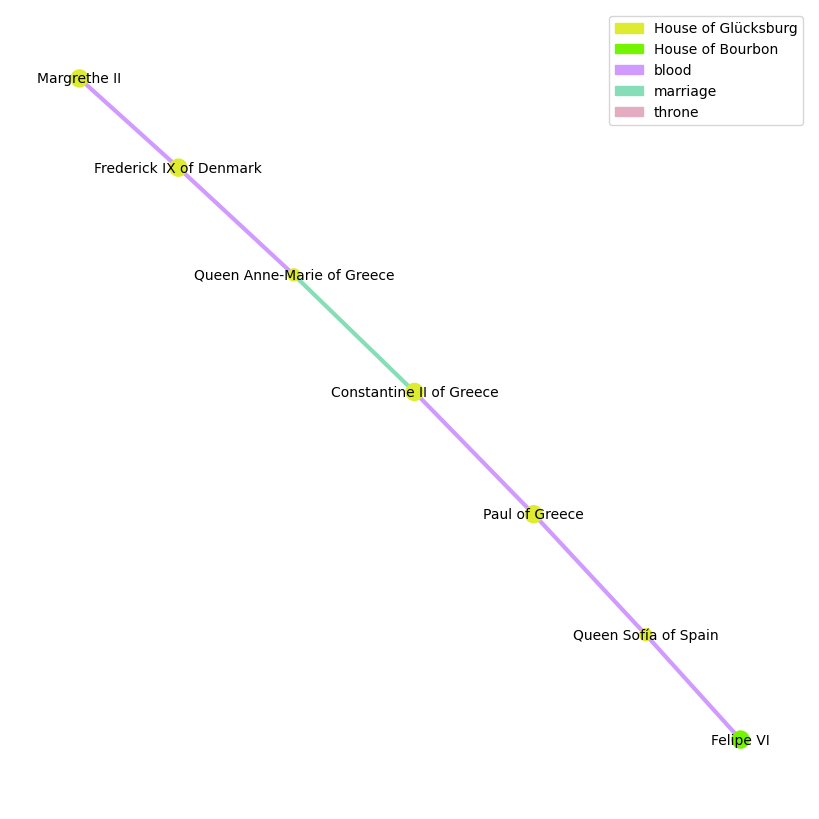

In [28]:
# Now try and draw the network so you can visualize the different houses and types of relationships between the nodes.

draw_network(shortest_path_subgraph, False, True, label_size = 10)

After having played a little bit with the paths between two specific monarchs, let's now compute the average path length for all nodes, which is useful to see how well connected the network is and if we can draw a short path between any pair of given monarchs or not.

In [29]:
# To calculate the average shortest path, we can only use connected graphs.
# In our case, it is. But by keeping this line we can generalize to other variations.
connected_components = nx.connected_components(G)
print("The size of the most connected components of the graph is: " + str([len(c) for c in sorted(connected_components, key=len, reverse=True)]))

# If we take a look at the components, we will get two of them. The biggest one is way bigger than the second one, this is why we will ignore the second subcomponent for now and focus on the biggest one.
GCC = [G.subgraph(c).copy() for c in nx.connected_components(G)][0]
avg_shortest_path = nx.average_shortest_path_length(GCC)
print("The average shortest path for the biggest connected component is: " + str(avg_shortest_path))

The size of the most connected components of the graph is: [7365]
The average shortest path for the biggest connected component is: 14.642864407423428


This average shortest path makes a lot of sense, because even though most monarchs are connected between each other (predecessor-successor link) , normally you will have to go minimum 3 generations back to find the common family member.


Another parameter that can tell us more about the structure of our graph is the cluster coefficient, which captures the degree to which the neighbors of a given node link to each other. We expect this to be low as we are modeling family relationships and even though they are very connected, the neighbors of a certain node don't tend to be connected very much between them because for example a granfather won't be connected (directly) to their grandson.

In [30]:
clustering_coefficient = nx.average_clustering(GCC)
print("The average clustering coefficient is: " + str(clustering_coefficient))

The average clustering coefficient is: 0.35091455613516254


As expected, it is not very high. But despite that, it is still higher than expected.

## Within the context of Monarchy

For centuries members of europen royal families often married closed relatives. This practice helped to consolidate power, titles and thrones. But as science has advanced, we now know that this can lead to problems regarding DNA and birth defects.

For our project, we wanted to use our network to perform an analysis on inbreeding in the context of royal families across Europe. To do this, we will be computing the coefficient of inbreeding (https://en.wikipedia.org/wiki/Coefficient_of_inbreeding) for each royal, to see if we come up with interesting results.

To compute the coefficient of inbreeding, we first need to compute the ascendance trees for each royal, which will help us to determine if two royals have ancestors in common.

After this, we will apply the formula which uses the distances between the target royal and the common ancestors of its parents and the inbreeding score of those common ancestors.

You can see the computation of ascendance trees and inbreeding scores in the network construction section under the attribute creation subsection.

An interesting fact to keep in mind now that we're starting this section is that the average inbreeding score in society is [1% according to this study](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0196360)

Nodes with inbreeding score > 15 : 63
Nodes with inbreeding score < 1 : 6125


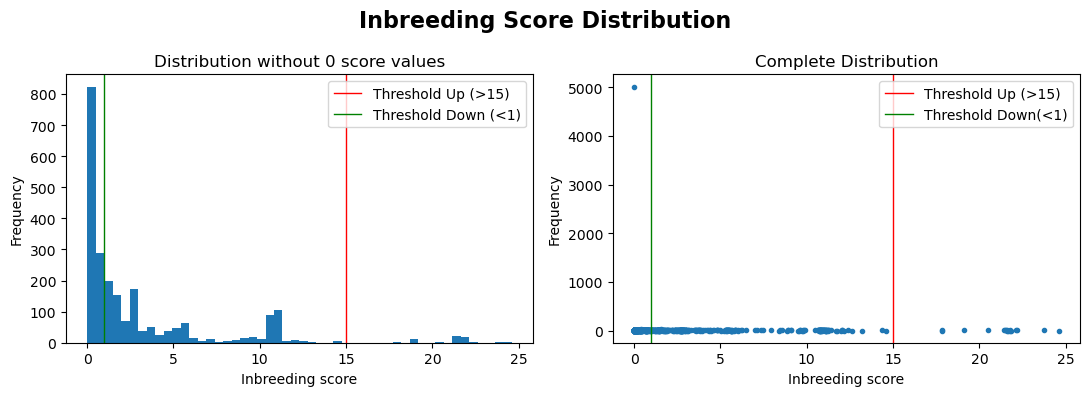

In [31]:

# make a list of all the inbreeding scores and multiply by 100 to have a percentage
node_names = list(G.nodes())
inbreed_scores = [G.nodes[node]['inbreed_score']*100 for node in node_names]
inbreed_scores_NOzeros = [i for i in inbreed_scores if i != 0  ]

# set the threshold value for which the imbreading score is considered high
#probability of having a child with a genetic disorder > ...% and
# lower threshold for which the imbreading score is considered low = not affecting the health of the child in any way


#  WE HAVE TO CHOSE THE THRESHOLD VALUE!!!! not the one below that are just for testing
threshold_up = 15 #np.mean(imbreed_scores_NOzeros) + 2*np.std(imbreed_scores_NOzeros)
threshold_down = 1



# function used to calculate the occurency of words in a list and set in a dictionary
def occurencies(list):
    occurencies = {}
    for i in list:
        occurencies[i] = occurencies.get(i, 0) + 1
    return occurencies

# plot subplot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(11, 4)
# text scale
fig.suptitle('Inbreeding Score Distribution', fontweight='bold', fontsize=16)

# ax1
ax1.hist(inbreed_scores_NOzeros, bins=50)
ax1.set_title("Distribution without 0 score values")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Inbreeding score")
ax1.axvline(threshold_up, color='red', linestyle='-', linewidth=1, label='Threshold Up (>15)')
ax1.axvline(threshold_down, color='green', linestyle='-', linewidth=1, label='Threshold Down (<1)')
ax1.legend()
# x ticks
#

# ax2 values and frequency
k_conf = occurencies(inbreed_scores).keys()
freq_conf = occurencies(inbreed_scores).values()

# ax2
ax2.plot(k_conf, freq_conf, ".")
ax2.set_title("Complete Distribution")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Inbreeding score")
ax2.axvline(threshold_up, color='red', linestyle='-', linewidth=1, label='Threshold Up (>15)')
ax2.axvline(threshold_down, color='green', linestyle='-', linewidth=1, label='Threshold Down(<1)')
ax2.legend()
# ax2.set_xticks(range(0, int(max(imbreed_scores))))

plt.tight_layout()

print(f"Nodes with inbreeding score > {threshold_up} :", len([i for i in inbreed_scores if i > threshold_up ]))
print(f"Nodes with inbreeding score < {threshold_down} :", len([i for i in inbreed_scores if i < threshold_down]))



**Figure 1.4** <br>
The figure above shows the Inbreeding Score Distribution both :
* cleaned from 0 imbreeding score values (for better visualization of the distibution shape);
*  the complete distibution.
How it could be seen, the two separate visualizations are needed as the frequency of the 0 value of the inbreeding score its in a completly different order of magnitude.

While the vast majority of nodes have Inbreeding scores around 0, 112 nodes have been selected as having extremely high Inbreeding Scores  (value>20), which means they have had from  1/5 to ~ 1/2 chance of inheriting the same allel from both parents. Which, if he end up to be having recesseive treat in the homoxigotic allel , it could have lead to extremely high health issues (e.g : Cystic Fibrosis, Sickle Cell Anemia,
Thalassemia and much others).

Following, are printed out the 10 people with higher imbreeding score as well as the number of nodes with inbreeding score over 0.01

In [32]:
# extract all the nodes names and put in a list
node_names = list(G.nodes())


#create diuctionary with all nodes names and scores
my_dict_imbr = dict(zip(node_names, inbreed_scores))
sorted_dict_imbr = dict(sorted(my_dict_imbr.items(), key=lambda item: item[1], reverse=True)) # Sort the dictionary by values in descending order

# Visualize the 10 persons with higher inbreeding score :
first_10_items = dict(list(sorted_dict_imbr.items())[:10])
print("The 10 persons with higher inbreeding score are : ",first_10_items)
print("\n\nThe number of people with an inbreeding score greater than 0.01 is:", len([i for i in inbreed_scores if i > 0.01]) , "of a total of" ,len(node_names),"nodes.")
print(f"Which means that {round((len([i for i in inbreed_scores if i > 0.01])/ len(node_names))*100,2)}% of nodes have an inbreeding score greater than 0.01")

The 10 persons with higher inbreeding score are :  {'Wilhelmina Maria Frederica of Rochlitz': 24.595069885253906, 'Charles II of Spain': 23.71349334716797, 'Philip Prospero, Prince of Asturias': 23.71349334716797, 'Prince Augustus of Prussia': 22.15498685836792, 'Prince Louis Ferdinand of Prussia (1772–1806)': 22.15498685836792, 'Princess Louise of Prussia (1770–1836)': 22.15498685836792, 'Princess Maria Antonietta of Bourbon-Two Sicilies': 22.0896735903807, 'Princess Maria Carolina of Bourbon-Two Sicilies (1856–1941)': 22.0896735903807, 'Prince Umberto, Count of Salemi': 21.801145975769032, 'Princess Maria Carolina of Bourbon-Two Sicilies (1822–1869)': 21.79920873604715}


The number of people with an inbreeding score greater than 0.01 is: 2248 of a total of 7365 nodes.
Which means that 30.52% of nodes have an inbreeding score greater than 0.01


As we can see, the person with the highest inbreeding score is *Charles II of Spain* on of the most well known monarchs due to his severe health problems attributed to inbreeding, which is not surprising given the track record his family - the Habsburgs - had with this practice.

## Inbreeding throughout time

In [33]:
# list of nodes devide in two groups: before and after 1750
nodes_before =[]
nodes_after =[]
no_death = []

# set threshold years (try to have similar amount of compared data at the end )
before= 1701
after = 1920

for name in G.nodes():
    #check if the node has a death date
    if G.nodes[name]["death"] == None:
        # if not the death rate check the birth date, if not discard the node
        if G.nodes[name]["birth"] == None:
            no_death.append(name)
            continue
        else:
            # 60 years before and after is added to the threshold
            # to take into account the fact that the are using the birth date i  instead of the death date
            if int(G.nodes[name]["birth"]) < before-55 and int(G.nodes[name]["birth"]) :
                nodes_before.append(name)
            if int(G.nodes[name]["birth"]) > after+55:
                nodes_after.append(name)
    else:
        if int(G.nodes[name]["death"]) < before and int(G.nodes[name]["death"]) :
            nodes_before.append(name)
        if int(G.nodes[name]["death"]) > after:
            nodes_after.append(name)
print("Here the number of nodes for each time sub-group is wisualized:")
print(f"Nodes before {before} are  :", len(nodes_before))
print(f"Nodes after {after} are :", len(nodes_after))
#print("Nodes with no death:", len(no_death))

# with ONLY imbreeding score != 0 for visualization purpose
imbreed_scores_before = [G.nodes[node]['inbreed_score']*100 for node in nodes_before if G.nodes[node]['inbreed_score'] > 0]
imbreed_scores_after = [G.nodes[node]['inbreed_score']*100 for node in nodes_after if (G.nodes[node]['inbreed_score'] > 0)]

print("Nodes with imbreeding score > 0 before:", len(imbreed_scores_before))
print("Nodes with imbreeding score > 0 after:", len(imbreed_scores_after))

#percentage of nodes with imbreeding score < 0
print("\n Percentage of nodes with imbreeding score < 0 before:", round((len(nodes_before)- len(imbreed_scores_before))/len(nodes_before)*100 ,0), "%")
print("\n Percentage of nodes with imbreeding score < 0 after:",round( (len(nodes_after)- len(imbreed_scores_after))/len(nodes_after)*100 ,0), "%")


Here the number of nodes for each time sub-group is wisualized:
Nodes before 1701 are  : 2472
Nodes after 1920 are : 1214
Nodes with imbreeding score > 0 before: 547
Nodes with imbreeding score > 0 after: 549

 Percentage of nodes with imbreeding score < 0 before: 78.0 %

 Percentage of nodes with imbreeding score < 0 after: 55.0 %


Here the number of nodes for each time sub-group is wisualized:
Nodes before 1701 are  : 2472
Nodes after 1920 are : 1214
Nodes with imbreeding score > 0 before: 547
Nodes with imbreeding score > 0 after: 549

 Percentage of nodes with imbreeding score < 0 before: 78.0 %

 Percentage of nodes with imbreeding score < 0 after: 55.0 %


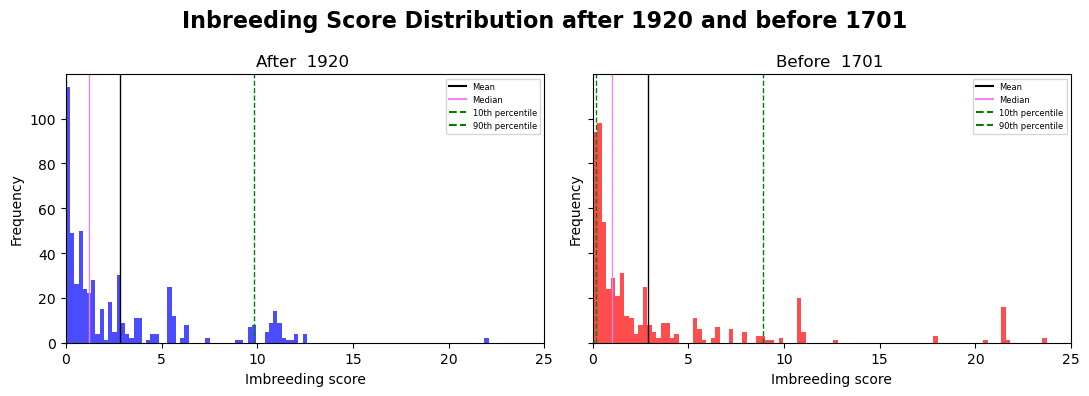

Median before: 1.03
Median after: 1.19


In [34]:

# Subplot comparing imbreed_scores_after_1750 against imbreed_scores_before_1750 distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

# Figure title
fig.suptitle(f'Inbreeding Score Distribution after {after} and before {before}', fontweight='bold', fontsize=16)

# Create histograms for each set of scores
hist_after_1750 = ax1.hist(imbreed_scores_after, bins=100, color='blue', alpha=0.7, label='After 1750')
hist_before_1750 = ax2.hist(imbreed_scores_before, bins=100, color='red', alpha=0.7, label='Before 1750')

# Set x-axis limits for better comparison
x_min, x_max = min(min(imbreed_scores_before),min(imbreed_scores_after)), max(max(imbreed_scores_before), max(imbreed_scores_after))+1
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)

# Set x-axis ticks at intervals of 10
xticks_interval = 5
ax1.set_xticks(np.arange(x_min, x_max + 1, xticks_interval))
ax2.set_xticks(np.arange(x_min, x_max + 1, xticks_interval))

# Calculate statistics for each set of scores
mean_after = np.mean(imbreed_scores_after)
mean_before= np.mean(imbreed_scores_before)
median_after = np.median(imbreed_scores_after)
median_before = np.median(imbreed_scores_before)
percentile_10_after= np.percentile(imbreed_scores_after, 10)
percentile_10_before = np.percentile(imbreed_scores_before, 10)
percentile_90_after = np.percentile(imbreed_scores_after, 90)
percentile_90_before = np.percentile(imbreed_scores_before, 90)

# Add vertical lines for the statistics
ax1.axvline(mean_after, color='black', linestyle='solid', linewidth=1)
ax1.axvline(median_after, color='violet', linestyle='solid', linewidth=1)
ax1.axvline(percentile_10_after, color='green', linestyle='dashed', linewidth=1)
ax1.axvline(percentile_90_after, color='green', linestyle='dashed', linewidth=1)

ax2.axvline(mean_before , color='black', linestyle='solid', linewidth=1, label='Dashed lines')
ax2.axvline(median_before, color='violet', linestyle='solid', linewidth=1)
ax2.axvline(percentile_10_before, color='green', linestyle='dashed', linewidth=1)
ax2.axvline(percentile_90_before, color='green', linestyle='dashed', linewidth=1)

# Add legends, labels, and titles to the plot
ax1.set_xlabel('Imbreeding score')
ax1.set_ylabel('Frequency')
ax1.set_title(f'After  {after} ')
ax1.legend()

ax2.set_xlabel('Imbreeding score')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Before  {before} ')
ax2.legend()
# list of nodes devide in two groups: before and after 1750
nodes_before =[]
nodes_after =[]
no_death = []

# set threshold years (try to have similar amount of compared data at the end )
before= 1701
after = 1920

for name in G.nodes():
    #check if the node has a death date
    if G.nodes[name]["death"] == None:
        # if not the death rate check the birth date, if not discard the node
        if G.nodes[name]["birth"] == None:
            no_death.append(name)
            continue
        else:
            # 60 years before and after is added to the threshold
            # to take into account the fact that the are using the birth date i  instead of the death date
            if int(G.nodes[name]["birth"]) < before-55 and int(G.nodes[name]["birth"]) :
                nodes_before.append(name)
            if int(G.nodes[name]["birth"]) > after+55:
                nodes_after.append(name)
    else:
        if int(G.nodes[name]["death"]) < before and int(G.nodes[name]["death"]) :
            nodes_before.append(name)
        if int(G.nodes[name]["death"]) > after:
            nodes_after.append(name)
print("Here the number of nodes for each time sub-group is wisualized:")
print(f"Nodes before {before} are  :", len(nodes_before))
print(f"Nodes after {after} are :", len(nodes_after))
#print("Nodes with no death:", len(no_death))

# with ONLY imbreeding score != 0 for visualization purpose
imbreed_scores_before = [G.nodes[node]['inbreed_score']*100 for node in nodes_before if G.nodes[node]['inbreed_score'] > 0]
imbreed_scores_after = [G.nodes[node]['inbreed_score']*100 for node in nodes_after if (G.nodes[node]['inbreed_score'] > 0)]

print("Nodes with imbreeding score > 0 before:", len(imbreed_scores_before))
print("Nodes with imbreeding score > 0 after:", len(imbreed_scores_after))

#percentage of nodes with imbreeding score < 0
print("\n Percentage of nodes with imbreeding score < 0 before:", round((len(nodes_before)- len(imbreed_scores_before))/len(nodes_before)*100 ,0), "%")
print("\n Percentage of nodes with imbreeding score < 0 after:",round( (len(nodes_after)- len(imbreed_scores_after))/len(nodes_after)*100 ,0), "%")

# Add legends, labels, and title to the plot
colors = {"Mean": 'black', "Median": 'violet', "10th percentile": 'green', "90th percentile": 'green'}
labels = list(colors.keys())
handles = [plt.Line2D([0], [0], color=colors[label], linestyle='-' if label == "Mean" or label =="Median" else '--') for label in labels]
ax1.legend(handles, labels, fontsize=6,)
ax2.legend(handles, labels, fontsize=6,)


plt.tight_layout()
plt.show()
print("Median before:", round(median_before,2))
print("Median after:", round(median_after,2))


 **Figure 1.5**

In the figure above a inbreeding score distibution comparison between the two sub-gourps (lived before 1701 /ref{} and after 1920 /ref{}) is done.
Two threshold were chosen to extract two sub-groups of similiar size (after removing 0 inbreeding score nodes) to create a visual comparable distibution.      In addition, the two dates where chosen as being two historical thresholds well known for being breaking points of scientific and social changes (start of 18th century, the "Roaring Twenties")

Analysing the figure it could be noticed that differently as it was expectedat at the beginning the median value for the gorup after 1900 result even higher that the one of before 1700.(Our first guess was to find a smaller value as inbreeding European Royal families back in the day is a really well known fact.) However, taking a closer look and making more research about inbreeding score the found  distibution could be really well explaned with the inbreeding score theroy. In fact, the inbreeding score for a population is a factor that grows in time if inbreeding behaviour continue,even with very distance relatives (as seen in the inbreeding formula) , which well explain the general slight shift of the "after 1920"  distibution to slightly higher values coming to the lower end of the distibution (It could be also noticed, that the $%$ of nodes with inbreeding score = 0 drop from  $78%$ to arounf $55%$). In the same time, due to social changes and scientifical  discoveries about the genetic risk of inbreeding, the extreem high values (>15) are significatelly dropped. It could also be noticed that the only two oulier values with inbreeding score (>15) in the "After 1920" distibution belong to   Princess Maria Antonietta of Bourbon-Two Sicilies and Princess Maria Carolina of Bourbon-Two Sicilies are both part of the same House of Bourbon-Two Sicilies; well known for their high inbreeding history and discovered to be one of the most inbred families \ref{fig:inbreed_score_distribution}.

    However, it has to be taken in consideration that our inbreeding score for the more recent person will consider (for a small amount) the inbreeding score of the past people. So people with time get more and more imbreeded in some sort (is this a helth issue in long run? Check [imbreeding scientific article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5916862/))
    **still strange!!! we have to find a possible explantion!!**




"The 1900s Science and Technology: Overview ." U*X*L American Decades. . Retrieved November 15, 2023 from Encyclopedia.com: https://www.encyclopedia.com/social-sciences/culture-magazines/1900s-science-and-technology-overview


Osler, Margaret J. , Spencer, J. Brookes and Brush, Stephen G.. "Scientific Revolution". Encyclopedia Britannica, 26 Nov. 2019, https://www.britannica.com/science/Scientific-Revolution. Accessed 6 December 2023.

## Community and Family analysis

We will now analyze the connectedness of royal families and their relationship with inbreeding. It's worth noting that due to how Wikipedia sets a person's house and how it treats sub-families/branches, there are more general and more fine-grained families, which could be joined into one.

With a modularity score we can test how much more connected a subgraph is compared to the original one. This can be an indicator of the existance of communities within a graph.

In [35]:
def modularity(node_list):
    L = G.number_of_edges()
    community_graph = G.subgraph(node_list)
    Lc = community_graph.number_of_edges()
    kc = sum([G.degree(pers) for pers in node_list if pers in G])

    return (Lc / L) - (kc / (2*L))**2

We will analyze the average inbreeding score of each royal family, as well as their modularity, to see how well connected they are compared to the rest of the graph. We can see that there was clearly a tendency of some families to abuse inbreeding than others. Some examples of these are the houses of Habsburg and the Spanish Royal family, with average scores over 10%.

In [36]:
houses = defaultdict(list)
for name, attr in G.nodes().items():
    houses[attr['house']].append(name)

names = []
sizes = []
inbreedings = []
mods = []
for house, people in sorted(houses.items(), key=lambda item: len(item[1]), reverse=True):
    inbreeding_scores = [G.nodes[person]['inbreed_score'] for person in people]
    names.append(house)
    sizes.append(len(people))
    mods.append(np.round(modularity(people),5))
    inbreedings.append(np.mean(inbreeding_scores))
    #print(f'id: {house}, size: {len(people)}, modularity: {modularity(people):.4}, avg inbreeding: {np.mean(inbreeding_scores):.05}')

house_df = pd.DataFrame({'name':names, 'size':sizes, 'avg_inbreeding':inbreedings, 'modularity':mods})
filtered_house_df = house_df[house_df['size'] > 1]
sorted_filtered_df = filtered_house_df.sort_values(by=['avg_inbreeding'],ascending=False)
display(sorted_filtered_df[:10])

,name,size,avg_inbreeding,modularity
167,House of Bourbon-Braganza,2,0.094882,0.00008
7,House of Habsburg,113,0.075643,0.00921
47,Spanish royal family,22,0.065144,0.00155
69,Saxe-Gotha-Altenburg,14,0.059231,0.00105
18,House of Bourbon-Two Sicilies,56,0.055969,0.00456
163,Orléans,2,0.054498,-0.00000
8,House of Habsburg-Lorraine,108,0.041897,0.00622
129,List of margraves and electors of Brandenburg,3,0.038115,-0.00000
16,House of Orléans,66,0.038069,0.00530
6,House of Bourbon,113,0.036939,0.00441


**Table 2.1** <br>

Table of royal families and some of their metrics, sorted by their average inbreeding score.

We can also use a community detection algorithm such as louvain to see how different royal houses are joined into bigger ones. We can see, that as expected, some royal families form bigger ones. One example of this is the various branches of the Bourbon family uniting into one of the communities of highest modularity.

In [37]:
from community import community_louvain
from collections import defaultdict

coms = community_louvain.best_partition(G)
communities = defaultdict(list)
community_houses = defaultdict(lambda: defaultdict(int))
for pers, com in coms.items():
    communities[com].append(pers)
    community_houses[com][G.nodes[pers]['house']]+=1

ids = []
sizes = []
mods = []
top_houses = []
total_houses = []

num_houses = 4
for community, people in sorted(communities.items(), key=lambda item: modularity(item[1]), reverse=True):
    houses = sorted(community_houses[community].items(), key=lambda item: item[1], reverse=True)
    ids.append(community)
    sizes.append(len(people))
    mods.append(np.round(modularity(people),5))
    top_houses.append(houses[:num_houses])
    total_houses.append(len(houses))
    #print(f'id: {community}, size: {len(people)}, modularity: {modularity(people):.4}, houses:{houses[:num_houses]} + {len(houses)-num_houses} more')

community_df = pd.DataFrame({'id':ids, 'size':sizes, 'modularity':mods, 'top_houses':top_houses, 'num_houses':total_houses})
display(community_df[:20])

,id,size,modularity,top_houses,num_houses
0,15,441,0.05727,"[(None, 245), (House of Wettin, 36), (House of...",32
1,18,389,0.05213,"[(None, 148), (House of Habsburg, 50), (House ...",33
2,21,370,0.05201,"[(House of Habsburg-Lorraine, 62), (None, 57),...",27
3,12,363,0.04677,"[(None, 68), (House of Romanov, 34), (House of...",51
4,10,430,0.04578,"[(None, 360), (House of York, 19), (House of P...",19
5,29,319,0.03869,"[(None, 204), (House of Wettin, 46), (House of...",27
6,4,294,0.03593,"[(None, 70), (House of Hohenzollern, 42), (Hou...",42
7,28,258,0.03441,"[(House of Wittelsbach, 62), (None, 33), (Hous...",31
8,6,267,0.03310,"[(None, 94), (House of Hanover, 37), (House of...",26
9,11,262,0.03089,"[(None, 159), (House of Valois, 18), (House of...",33


**Table 2.2** <br>

Table of communities found within our network using the Louvain algorithm and the houses that are cointained within them. Sorted by modularity, so how well connected they are to the rest of the graph, "how well they form a community"

# TEXT ANALYSIS

1.0) Corpus creation

1)Wikitext exploration.

In this section a firstly a deep analysis of the all the wiki text will be performed to to extract a broad information about the overall word corpus:



* corpus and dictionary word  lenght
* lexical diversity among the corpus
* most common used words

2)Following, it could be found a wordcloud-plot comparison between high and low inbreeding scores groups.

3)Finally, an evaluation of the previously calculated sentiment score against high and low imbreeding score is performed

## Wiki text exploration

 This sub-section collects the wikitext of all nodes into a corpus. After tokenization, all words are converted to lowercase and all punctuation is removed. Finally, a customized list of stopwords (nltk english stopwords + frequent wikipedia formatting tokens) is removed for a clean dataset. This process prepares the corpus for efficient natural language processing and analysis within the network graph.

In [41]:
#Folder  where are saved the txt files with the text of the monarchs
preprocess_dir = r"C:\Users\david\Desktop\CORSI ORAAA\SOCIAL-GRAPH\Final_project\monarch_text"  # for pc
#preprocess_dir = r"/content/drive/MyDrive/Graph_1450/monarch_text"
#preprocess_dir = '/content/drive/MyDrive/DTU/Social Graphs 2023/monarch_text'

corpus_root = preprocess_dir

In [42]:
# Stop word list creation:
# Extraction of downloaded nltk english stopwords
stop_words = set(stopwords.words('english'))
# addition of customized stopwords
list_remove =["ref","url", "p", "http","https","www", "org", "com", "publisher", "file", "page", "html", "jpg", "br", "sfn"]
stop_words.update(list_remove)

# Function to calculate vocabulary size
def vocab_size(text):
    """ text: nltk.Text object"""

    words = text.tokens
    unique_words = set(words)
    return len(unique_words)

# function to remove punctuation
def remove_punctuation(tokens):
    # Define a string containing all punctuation characters
    punctuation_chars = string.punctuation +"'' ``"

    # Remove all punctuation characters from the list of tokens
    tokens_without_punctuation = [token  for token in tokens if token not in punctuation_chars]
    return tokens_without_punctuation

# set lower case
def set_lower_case(tokens):
    tokens_lowercase = [token.lower() for token in tokens]
    return tokens_lowercase

##remove punctuation and set lower case functions ##############################

def remove_punctuation_lower(tokens):
    # Define a string containing all punctuation characters
    punctuation_chars = string.punctuation +"'' ``"

    # Remove all punctuation characters from the list of tokens
    tokens_without_punctuation = [token.lower()  for token in tokens if token not in punctuation_chars]
    return tokens_without_punctuation

# function used to calculate the occurency of words in a list and set in a dictionary
def occurencies(list):
    occurencies = {}
    for i in list:
        occurencies[i] = occurencies.get(i, 0) + 1
    return occurencies

In [43]:
# corpus creation
corpus = PlaintextCorpusReader(corpus_root, ".*")
all_files_list = corpus.fileids() # list of alle the files in the corpus ("monarch corpus")
corpus_raw = corpus.raw() # raw text of the entire corpus ("monarch corpus")

# TOKENIZATION of the corpus

# takes to long to run (more then 30 minutes and still running!!)
#tokens = nltk.word_tokenize(corpus_raw) # tokenized corpus = list of tokens
wordlist = corpus.words()  # list of all the words/tokens in the corpus (

tokens_clean_lower = remove_punctuation_lower(wordlist)  # remove punctuation and set lower case
# create a text object from the corpus
text_obj = nltk.Text(tokens_clean_lower)

# vocabulary size (number of unique tokens in the corpus)
tokens_vocabulary_len = vocab_size(text_obj)


##### stop words- removal
tokens_clean_lower_NoStopWords = [word for word in tokens_clean_lower if word.isalpha() and word not in stop_words]
text_obj_NoStopWords = nltk.Text(tokens_clean_lower_NoStopWords)

1) Wikitext exploration:

To get a general overview of the analyzed corpus:

the corpus lenght (number of tokens in the corpus),  the number of unique tokens and the lexical diversity is extract*.

*The lexical diveristy is defined as :

$lexical\_diversity = distinct\_tokens / N\_tokens $ .

In [ ]:
print( "The lenght of the tokens in the corpus  before cleaning is :", len(wordlist) )
print("\n The Vocabulary of all the cleaned corpus has size:", tokens_vocabulary_len )

# lexical diversity among all the wikipedia pages
def lexical_diversity(text):
 return len(set(text)) / len(text)  #different vocabulary used/all words used

# calculate the percentage
def percentage(count, total):
    return 100 * count / total #percentage

div= lexical_diversity(text_obj)
print("\n Lexical diversity:", div,  f"\n It means that only {round(div*100,3)} % of the words are unique, the other {100- round(div*100,3)} % of the text is composed of the repetition of these words. ")

The lenght of the tokens in the corpus  before cleaning is : 24022415

 The Vocabulary of all the cleaned corpus has size: 275332

 Lexical diversity: 0.014602766067221985 
 It means that only 1.46 % of the words are unique, the other 98.54 % of the text is composed of the repetition of this words. 


## Most common words plot

In [ ]:
def frequency_words(tokens_clean_lower,n=75):
    # Tokenize the text (get all tokens from the text)
    words = tokens_clean_lower

    # Get the English stopwords
    stop_words = set(stopwords.words('english'))

    # Remove stopwords and non-alphabetic words  (isalpha() returns True if all characters in the string are alphabetic
    # then check if the word is not in the stop_words list) if both condition are True acccept the word
    #filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    filtered_words = [word.lower() for word in words if word.isalpha() ]

    # Create a frequency distribution of the filtered words
    fdist = nltk.FreqDist(filtered_words)

    # Get the 75 most frequent words (from FreqDist object!)
    most_common_words = fdist.most_common(n)

    return most_common_words

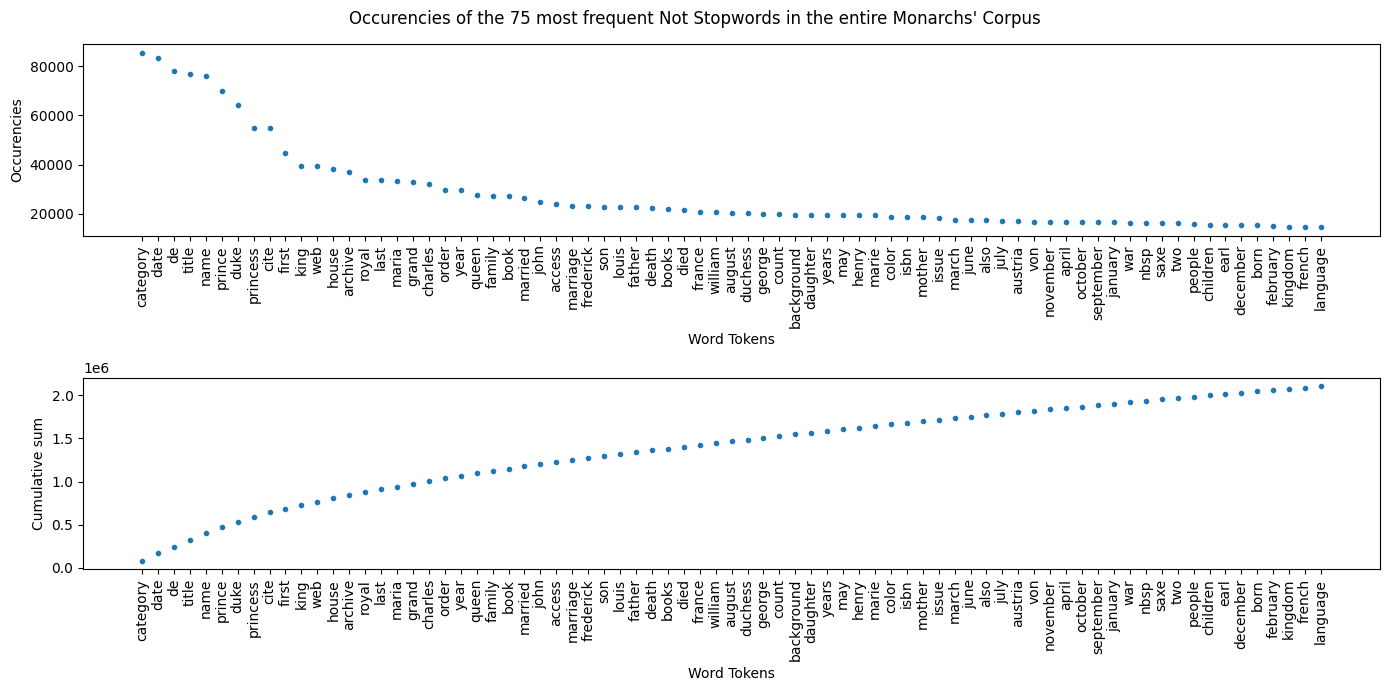

In [ ]:
def frequency_non_stopwords__1(tokens_clean_lower,n=75):
    # Tokenize the text (get all tokens from the text)
    words = tokens_clean_lower

    # Get the English stopwords
    stop_words = stopwords.words('english')

    list_remove =["ref","url", "p", "http", "https","www", "org", "com", "publisher", "file", "page", "html", "jpg", "br", "sfn", "ii", "iii","pp"]
    stop_words+= list_remove

    # Remove stopwords and non-alphabetic words  (isalpha() returns True if all characters in the string are alphabetic
    # then check if the word is not in the stop_words list) if both condition are True acccept the word
    filtered_words_1 = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    #filtered_words_1 = [word.lower() for word in filtered_words_1 if word.lower() not in stop_words]

    # Create a frequency distribution of the filtered words
    fdist = nltk.FreqDist(filtered_words_1)

    # Get the 75 most frequent words (from FreqDist object!)
    most_common_words_1 = fdist.most_common(n)

    return most_common_words_1

most_frequent_words__1 = frequency_non_stopwords__1(tokens_clean_lower)

# plot the histogram of the 75 most common words
k_1 ,freq_1 = zip(*most_frequent_words__1[:]) # remove the word  "ref"

fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle('Occurencies of the 75 most frequent Not Stopwords in the entire Monarchs\' Corpus')
# text scale
fig.set_size_inches(14, 7)


ax1.plot(k_1, freq_1, ".")

ax1.set_ylabel('Occurencies')
ax1.set_xlabel('Word Tokens')
ax1.set_xticks(range(len(k_1)))
ax1.set_xticklabels(k_1, rotation=90)



# ax2 cumulative distibution
ax2.plot(k_1, np.cumsum(list(freq_1)), ".")

ax2.set_ylabel('Cumulative sum')
ax2.set_xlabel('Word Tokens')
ax2.set_xticks(range(len(k_1)))
ax2.set_xticklabels(k_1, rotation=90)

plt.tight_layout()

plt.show()

**Figure 3.1** <br>  

The figure above shows the distibution of the firts 75 more common tokens.


## Word Clouds

### wordcloud all corpus

In [ ]:

freq_dict_1 = nltk.FreqDist(tokens_clean_lower_NoStopWords)


def TF(freq_dict_1, c=0 , normalization=True):
    # regolarization factor for balancing the different world count
    #tokens count east, tokens count west
    count_1 = 1#max(freq_dict_1.values())

    TF= []

    if normalization:
        for i in freq_dict_1.keys():
                TF.append( (i,  round(freq_dict_1[i]/count_1,3)  ) )

    TF_sorted = sorted(TF, key=lambda tup: tup[1], reverse=True)
    return TF_sorted

In [ ]:
TF_sorted = TF(freq_dict_1, c=0, normalization=True)

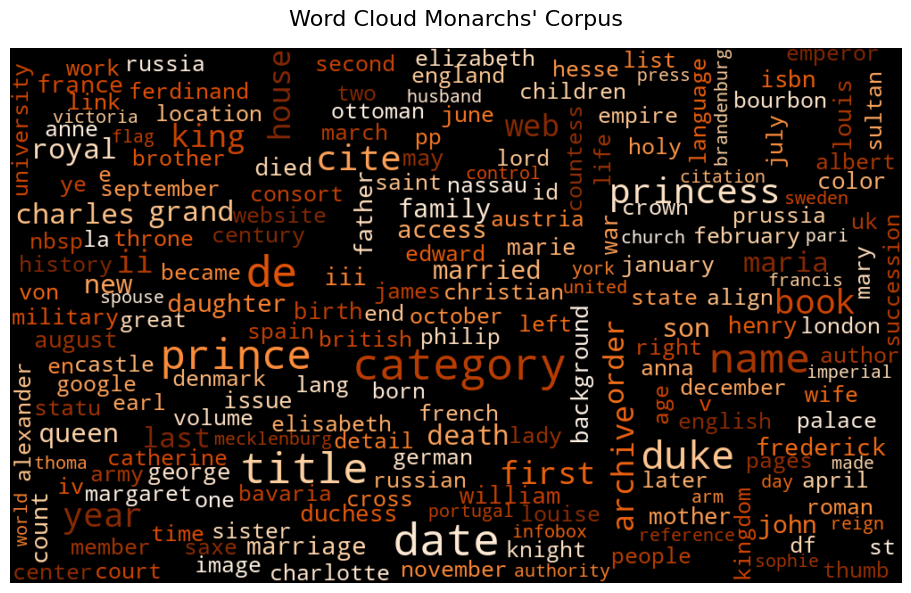

In [ ]:
# Creating a single string containing all the words for each corpus

word_cloud_list = [ "".join( (str(word[0])+" " )*int(word[1])) for word in TF_sorted]
west_cloud_string = "".join(word_cloud_list)

# Create and generate a word cloud image:
fig = plt.figure()
fig.set_size_inches(15, 6)  # size of the figure (the outside box)
fig.suptitle("Word Cloud Monarchs' Corpus", fontsize=16)

wordcloud_1 = WordCloud(width=1000, height=600,max_font_size=50,  collocations = False, colormap='Oranges_r').generate(west_cloud_string)


plt.imshow(wordcloud_1, interpolation="bilinear" ,)
#plt.title("Word Cloud Monarchs' Corpus", fontsize=14)
plt.axis("off")


plt.tight_layout(  )


plt.show()

**Figure 3.2<br>**

The figure above shows the word cloud with the most common used words of all the monarchs' corpus. As expected words related to royality as the titles  price, duke and princess are among the most frequent words.


### Word cloud comparison
Here,a wordcloud combarison between all nodes wiht an imbreeding score below the T_1  and above T_2 threshold is performed.
With the T_1 threshold () all nodes that.......

In [ ]:
# extract all the nodes names and put in a list
node_names = list(G.nodes())
#concert inbreeding score to a % value
#imbreed_scores = [G.nodes[node]['inbreed_score_NEW']*100 for node in node_names]

#create diuctionary with all nodes names and scores
my_dict_imbr = dict(zip(node_names, inbreed_scores))
# Sort the dictionary by values in descending order
sorted_dict_imbr = dict(sorted(my_dict_imbr.items(), key=lambda item: item[1], reverse=True))

# Visualize the 10 persons with higher inbreeding score :
first_10_items = dict(list(sorted_dict_imbr.items())[:30])
print("The 10 perosns with higher inbreeding score are : ",first_10_items)

print("\n \n The imbreading score which have a value different from  are :", len([i for i in inbreed_scores if i != 0]) , "froma a total number of node equal to : " ,len(node_names))


The 10 perosns with higher inbreeding score are :  {'Wilhelmina Maria Frederica of Rochlitz': 25.432991981506348, 'Charles II of Spain': 24.619770050048828, 'Philip Prospero, Prince of Asturias': 24.619770050048828, 'Princess Maria Carolina of Bourbon-Two Sicilies (1822–1869)': 24.364998913370073, 'Ferdinand Maria, Elector of Bavaria': 23.949432373046875, 'Archduchess Maria Maddalena of Austria': 23.883056640625, 'Anna of Tyrol': 23.883056640625, 'Archduchess Maria of Austria (1584–1649)': 23.883056640625, 'Leopold V, Archduke of Austria': 23.883056640625, 'Margaret of Austria, Queen of Spain': 23.883056640625, 'Ferdinand II, Holy Roman Emperor': 23.883056640625, 'Anne of Austria, Queen of Poland': 23.883056640625, 'Constance of Austria': 23.883056640625, 'Archduke Maximilian Ernest of Austria': 23.883056640625, 'Archduchess Eleanor of Austria (1582–1620)': 23.883056640625, 'Archduchess Gregoria Maximiliana of Austria': 23.883056640625, 'Archduchess Catherine Renata of Austria': 23.883

In [ ]:

nodes_up = [key for key, value in sorted_dict_imbr.items() if value > threshold_up ]
nodes_down = [key for key, value in sorted_dict_imbr.items() if value < threshold_down]

# create a corpus with the text of the nodes with high imbreeding score
def corpus_from_nodes(nodes_list, stop_words= stop_words, G=G):
    list_tokens= []
    for node in nodes_list:
        # extract tokens attribute from the node
        tokens = G.nodes[node]["tokens"]
        # removw not alphabetic words and stopwords
        tokens_NoStopWords = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

    #return corpus as a list of tokens
        list_tokens += tokens_NoStopWords
        corpus = nltk.Text(tokens_NoStopWords)

    return list_tokens , corpus



In [ ]:
tokens_upper_imbr_nostop , corpus_upper = corpus_from_nodes(nodes_up , stop_words= stop_words, G=G)
tokens_lower_imbr_nostop , corpus_lower = corpus_from_nodes(nodes_down , stop_words= stop_words, G=G)
print("Len tokens upper imbr:", len(tokens_upper_imbr_nostop))
print("Len tokens lower imbr:", len(tokens_lower_imbr_nostop))


Len tokens upper imbr: 82356
Len tokens lower imbr: 4972825


In [ ]:
genetic_disorders = ['Hemophilia','Cystic Fibrosis','Huntington\'s Disease','Tay-Sachs Disease','Autosomal Recessive Disorders','Mental Retardation',
    'Neurofibromatosis','Schizophrenia','Bipolar Disorder','Inherited Neuromuscular Disorders','Down Syndrome','Turner Syndrome',
    'Klinefelter Syndrome','Marfan Syndrome','Sickle Cell Anemia','Thalassemia','Spinal Muscular Atrophy','Albinism','Phenylketonuria (PKU)',
    'Fragile X Syndrome','Williams Syndrome','Gaucher Disease','Muscular Dystrophy','Cerebral Palsy','Ehlers-Danlos Syndrome','Rett Syndrome',
    'Polycystic Kidney Disease','Prader-Willi Syndrome','Cri du Chat Syndrome', "mad"]


In [ ]:
freq_dict_upper = nltk.FreqDist(tokens_upper_imbr_nostop)
freq_dict_lower = nltk.FreqDist(tokens_lower_imbr_nostop)

def TF_TR(freq_dict_1, freq_dict_2, c=1, normalization=True , DIS=1):
    # regolarization factor for balancing the different world count
    #tokens count east, tokens count west
    count_1 = sum(freq_dict_1.values())
    count_2 = sum(freq_dict_2.values())

    disorder_count = 0
    TF_TR = []

    if normalization:
        for i in freq_dict_1.keys():
            if i in freq_dict_2.keys():
                if i in genetic_disorders:
                    TF_TR.append((i, round( ((freq_dict_1[i]/count_1 )   /(freq_dict_2[i]/count_2 ))*DIS  ,4) ))
                    disorder_count +=1
                else:
                    TF_TR.append((i, round( (freq_dict_1[i]/count_1 )   /(freq_dict_2[i]/count_2 )  ,4) ))

            else:
                if i in genetic_disorders:
                    TF_TR.append((i, round ( ((freq_dict_1[i]/count_1 )/c) *DIS ,4) ))
                    disorder_count +=1
                else:
                    TF_TR.append((i, round ( (freq_dict_1[i]/count_1 )/c ,4) ))
    else:
        for i in freq_dict_1.keys():
                if i in freq_dict_2.keys():
                    TF_TR.append((i, round(freq_dict_1[i]/freq_dict_2[i],2) ))
                else:
                    TF_TR.append((i, round (freq_dict_1[i]/c ,2) ))


    TF_TR_sorted = sorted(TF_TR, key=lambda tup: tup[1], reverse=True)
    print("disorder count:", disorder_count)
    return TF_TR_sorted

#calculate TF_TR for the two corpus (upper and lower imbreeding score)

TF_TR_upper = TF_TR(freq_dict_upper, freq_dict_lower, c=1, normalization=True)


TF_TR_lower = TF_TR(freq_dict_lower, freq_dict_upper, c=1, normalization=True)

# create a list and string with the words repeated according to their TF_TR score ( needed for the wordcloud)

upper_cloud_list = [ "".join( (str(word[0])+" " )*int(word[1])) for word in TF_TR_upper]
# add a word 20000 times to make it appear in the wordcloud
#upper_cloud_list.append("UPPERMY "*20000)


upper_cloud_string = "".join(upper_cloud_list)#
# add a word wit

lower_cloud_list = [ "".join( (str(word[0])+" " )*int(word[1])) for word in TF_TR_lower]
lower_cloud_string = "".join(lower_cloud_list)


disorder count: 1
disorder count: 1


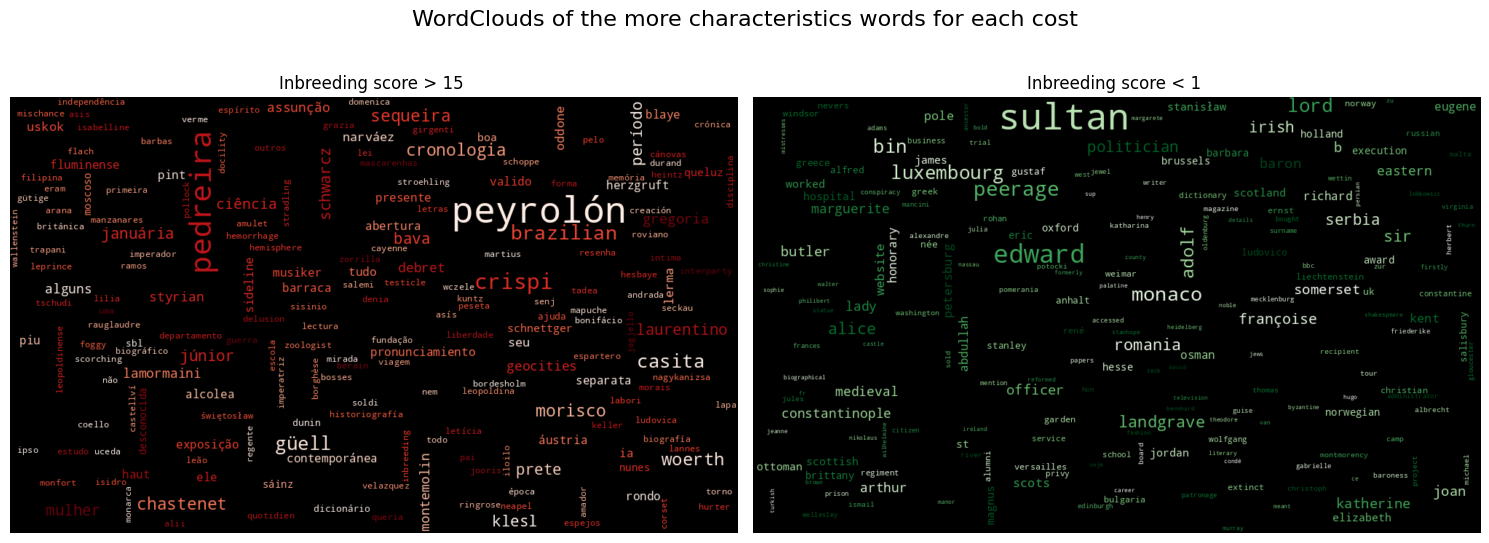

The number of tokens inside the group with inbreeding score above (>15) are : 911896
The number of tokens inside the group with inbreeding score less then (<1) are  43861


In [ ]:
# create word cloud obj
wordcloud_upper = WordCloud(width=1000, height=600,max_font_size=50,  collocations = False, colormap= 'Reds').generate(upper_cloud_string)
wordcloud_lower = WordCloud(width=1000, height=600,max_font_size=50,  collocations = False, colormap='Greens').generate(lower_cloud_string)

#create figure
fig = plt.figure()
fig.set_size_inches(15, 6)  # size of the figure (the outside box)
fig.suptitle('WordClouds of the more characteristics words for each cost', fontsize=16)

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_upper, interpolation="bilinear" ,)
plt.title(f"Inbreeding score > {threshold_up} ")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_lower, interpolation="bilinear")
plt.title(f"Inbreeding score < {threshold_down} ")
plt.axis("off")

plt.tight_layout(  )
plt.show()

#shows the nummber of tokens considerated in each group (could be removed at the end)
print( "The number of tokens inside the group with inbreeding score above (>15) are :",len(upper_cloud_string))
print( "The number of tokens inside the group with inbreeding score less then (<1) are ",len(lower_cloud_string))


**Figure 3.3** <br>
From the wordcloud comparison above it could be seen that no particular  words concerning inbreeding issues were found in the group for high healt risk  from the inbreeding score. As it could be seen in the wordcloud of high inbred individuals not any word  rilevant to helth or inbreeding was found.

# SENTIMENT ANALYSIS

Finally, we'll run multiple sentiment analysis with different dictionaries, to see if there is a difference within the texts of inbred and non inbred people

## Sentiment score from the sentiment score analyzer




In [ ]:
#the lists nodes_up and nodes_down that refers to nodes with particularly high inbreeding score helath risk
# and low risk were defined in the subsection above Wordcloud comparison

# create a list for the two groups for high, low imbreeding extracting their seniment score
sentiment_scores_up = [G.nodes[node]['sentiment_score_2'] for node in nodes_up]
sentiment_scores_down = [G.nodes[node]['sentiment_score_2'] for node in nodes_down]  #helt score


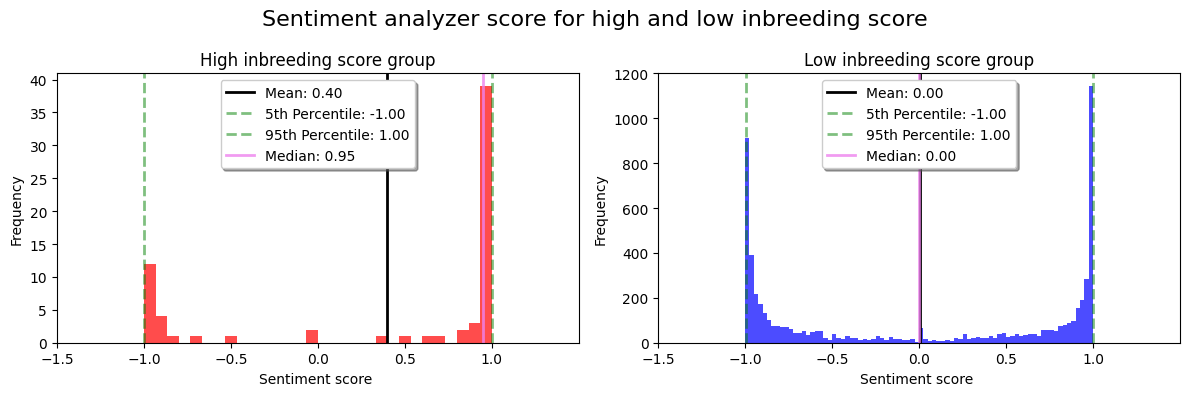

In [ ]:
# Subplot comparing imbreed_scores_up against imbreed_scores_down distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# Figure title
fig.suptitle('Sentiment analyzer score for high and low inbreeding score', fontsize=16)

# Create histograms for each set of scores with density=True for percentage
hist_up = ax1.hist(sentiment_scores_up, bins=30, color='red', alpha=0.7,  density=False)
hist_down = ax2.hist(sentiment_scores_down, bins=80, color='blue', alpha=0.7,  density=False)

# Set x-axis limits for better comparison
x_min, x_max = min(min(sentiment_scores_up), min(sentiment_scores_down) -0.5), max(
    max(sentiment_scores_up) + 0.5, max(sentiment_scores_down)
)
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)

# Calculate statistics for each set of scores
mean_up = np.mean(sentiment_scores_up)
percentile_5_up = np.percentile(sentiment_scores_up, 5)
percentile_95_up = np.percentile(sentiment_scores_up, 95)
median_up = np.median(sentiment_scores_up)

mean_down = np.mean(sentiment_scores_down)
percentile_5_down = np.percentile(sentiment_scores_down, 5)
percentile_95_down = np.percentile(sentiment_scores_down, 95)
median_down = np.median(sentiment_scores_down)

# Add legends, labels, and titles to the plot
ax1.axvline(mean_up, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_up:.2f}')
ax1.axvline(percentile_5_up, color='green', linestyle='dashed', linewidth=2, label=f'5th Percentile: {percentile_5_up:.2f}', alpha=0.5)
ax1.axvline(percentile_95_up, color='green', linestyle='dashed', linewidth=2, label=f'95th Percentile: {percentile_95_up:.2f}', alpha=0.5)
ax1.axvline(median_up, color='violet', linestyle='-', linewidth=2, label=f'Median: {median_up:.2f}', alpha=0.8)

ax2.axvline(mean_down, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_down:.2f}')
ax2.axvline(percentile_5_down, color='green', linestyle='dashed', linewidth=2, label=f'5th Percentile: {percentile_5_down:.2f}', alpha=0.5)
ax2.axvline(percentile_95_down, color='green', linestyle='dashed', linewidth=2, label=f'95th Percentile: {percentile_95_down:.2f}', alpha=0.5)
ax2.axvline(median_down, color="violet", linestyle='-', linewidth=2, label=f'Median: {median_down:.2f}', alpha=0.8)

# Add legends, labels, and titles to the plot
legend1 = ax1.legend(loc='upper right', shadow=True, fontsize='small')
legend1.get_frame().set_facecolor('C0')

legend2 = ax2.legend(loc='upper right', shadow=True, fontsize='small')
legend2.get_frame().set_facecolor('C1')
ax1.legend(loc='upper center', fancybox=True, shadow=True)

ax1.set_xlabel('Sentiment score ')
ax1.set_ylabel('Frequency')
ax1.set_title('High inbreeding score group')
ax1.legend(loc='upper center', fancybox=True, shadow=True)

ax2.set_xlabel('Sentiment score ')
ax2.set_ylabel('Frequency')
ax2.set_title('Low inbreeding score group')
ax2.legend(loc='upper center', fancybox=True, shadow=True)
plt.tight_layout()
# Show the plot
plt.show()


**Figure 4.1** <br>
The figure above shows that the sentiment score analyzer for the High inbreed group

## Sentiment score LabMT

We'll test the dictionary used in class for happy/sad topics, to see if we can see a pattern.

In [ ]:
#the lists nodes_up and nodes_down that refers to nodes with particularly high inbreeding score helath risk
# and low risk were defined in the subsection above Wordcloud comparison

# create a list for the two groups for high, low imbreeding extracting their seniment score
sentiment_scores_up_1 = [G.nodes[node]['sentiment_score_1'] for node in nodes_up]
sentiment_scores_down_1 = [G.nodes[node]['sentiment_score_1'] for node in nodes_down]  #helt score


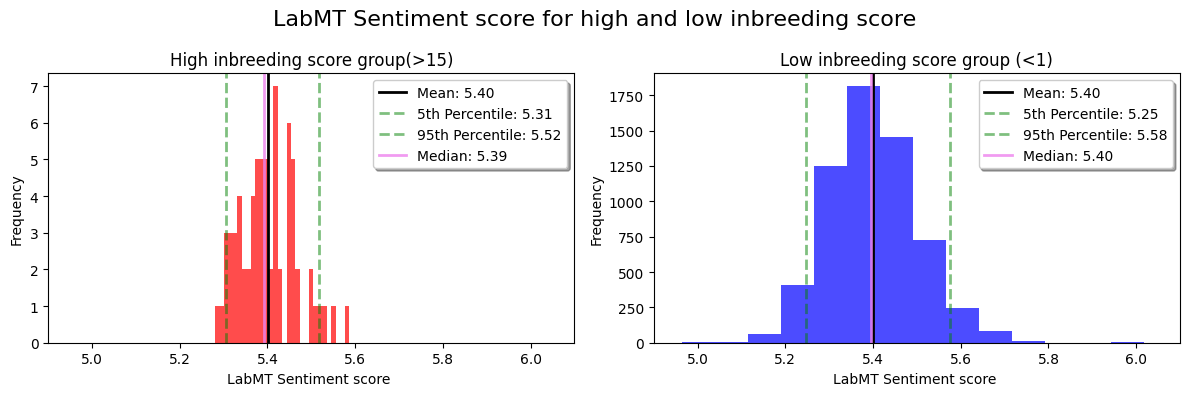

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# Figure title
fig.suptitle('LabMT Sentiment score for high and low inbreeding score', fontsize=16)

# Create histograms for each set of scores with density=True for percentage
hist_up = ax1.hist(sentiment_scores_up_1, bins=30, color='red', alpha=0.7,  density=False)
hist_down = ax2.hist(sentiment_scores_down_1, bins=80, color='blue', alpha=0.7,  density=False)

# Set x-axis limits for better comparison
#x_min, x_max = min(min(sentiment_scores_up_1), min(sentiment_scores_down_1) -0.5), max(
 #   max(sentiment_scores_up_1) + 0.5, max(sentiment_scores_down_1)

#ax1.set_xlim(x_min, x_max)
ax2.set_xlim(4.9, 6.1)
ax1.set_xlim(4.9, 6.1)
# Calculate statistics for each set of scores
mean_up = np.mean(sentiment_scores_up_1)
percentile_5_up = np.percentile(sentiment_scores_up_1, 5)
percentile_95_up = np.percentile(sentiment_scores_up_1, 95)
median_up = np.median(sentiment_scores_up_1)

mean_down = np.mean(sentiment_scores_down_1)
percentile_5_down = np.percentile(sentiment_scores_down_1, 5)
percentile_95_down = np.percentile(sentiment_scores_down_1, 95)
median_down = np.median(sentiment_scores_down_1)

# Add legends, labels, and titles to the plot
ax1.axvline(mean_up, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_up:.2f}')
ax1.axvline(percentile_5_up, color='green', linestyle='dashed', linewidth=2, label=f'5th Percentile: {percentile_5_up:.2f}', alpha=0.5)
ax1.axvline(percentile_95_up, color='green', linestyle='dashed', linewidth=2, label=f'95th Percentile: {percentile_95_up:.2f}', alpha=0.5)
ax1.axvline(median_up, color='violet', linestyle='-', linewidth=2, label=f'Median: {median_up:.2f}', alpha=0.8)

ax2.axvline(mean_down, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_down:.2f}')
ax2.axvline(percentile_5_down, color='green', linestyle='dashed', linewidth=2, label=f'5th Percentile: {percentile_5_down:.2f}', alpha=0.5)
ax2.axvline(percentile_95_down, color='green', linestyle='dashed', linewidth=2, label=f'95th Percentile: {percentile_95_down:.2f}', alpha=0.5)
ax2.axvline(median_down, color='violet', linestyle='-', linewidth=2, label=f'Median: {median_down:.2f}', alpha=0.8)

# Add legends, labels, and titles to the plot
legend1 = ax1.legend(loc='upper right', shadow=True, fontsize='small')
legend1.get_frame().set_facecolor('C0')

legend2 = ax2.legend(loc='upper right', shadow=True, fontsize='small')
legend2.get_frame().set_facecolor('C1')
ax1.legend(loc='upper center', fancybox=True, shadow=True)

ax1.set_xlabel('LabMT Sentiment score ')
ax1.set_ylabel('Frequency')
ax1.set_title('High inbreeding score group(>15)')
ax1.legend( fancybox=True, shadow=True)

ax2.set_xlabel('LabMT Sentiment score ')
ax2.set_ylabel('Frequency')
ax2.set_title('Low inbreeding score group (<1)')
ax2.legend( fancybox=True, shadow=True)
plt.tight_layout()
# Show the plot
plt.show()

**Figure 4.1** <br>
The figure above shows comparison of the LabMT distibution for the two groups:high (>15) and low(<1) inbreeding score.
As it could be seen both the distibution appear to have a Normal shape, and have also the same exact mean.
With this analysis, a difference in the wikitext  sentiment using the was searched for high and low inbreeding persons, however any significant result was found.